In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as stats
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from scipy.spatial import distance_matrix
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from sklearn.cluster import BisectingKMeans

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
continuous_col = ['length_ms', 'frame_count', 'intensity', 'zero_crossings_sum', 'mean', 'std', 'min', 'max', 'kur', 
                      'skew', 'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min', 'sc_max', 
                      'sc_kur', 'sc_skew', 'stft_mean', 'stft_std', 'stft_min', 'stft_max', 'stft_kur', 'stft_skew']
continuous_col_to_delete = ['frame_count', 'mean', 'stft_max', 'min', 'max', 'stft_mean', 'mfcc_min', 'intensity']
continuous_col_to_keep = [col for col in continuous_col if col not in continuous_col_to_delete]

discrete_col = ['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 
                    'sex', 'channels', 'sample_width', 'frame_rate', 'frame_width']
discrete_col_to_delete = ['modality', 'channels', 'sample_width', 'actor', 'frame_rate', 'frame_width']
discrete_col_to_keep = [col for col in discrete_col if col not in discrete_col_to_delete]

In [4]:
df_train = pd.read_csv("ravdess_features_base.csv")
original_df = df_train.copy()

In [5]:
df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_train = df_train[continuous_col_to_keep]

Volendo applicare il dbscan, che è un algoritmo di clustering basato sulle distanze, restringo il mio dataset alle sole variabili continue.

# DBSCAN clustering

In [6]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train)

Normalizzo il dataset di modo che tutte le variabili abbiano lo stesso peso nel calcolo delle distanze.

In [7]:
D = squareform(pdist(train_data))

In [8]:
eps_list = np.arange(0.2, 0.5+0.01, 0.01)
min_samples_list = np.arange(4, 10+1, 1)
silhouette_list = list()

In [9]:
for min_samples in min_samples_list:
    temp_silhouette = list()
    for eps in eps_list:
        dbscan = DBSCAN(min_samples=min_samples, eps=eps, metric='euclidean')
        dbscan.fit(train_data)
        unique_labels = np.unique(dbscan.labels_)
        if len(unique_labels) > 2:
            idx = dbscan.labels_ != -1
            silhouette = silhouette_score(D[idx][:, idx], dbscan.labels_[idx], metric='precomputed')
            if np.isnan(silhouette):
                temp_silhouette.append(-2)
            else:
                temp_silhouette.append(silhouette)
        else:
            temp_silhouette.append(-2)
    silhouette_list.append(temp_silhouette)

Calcolo il silhoutte score al variare dei parametri min_samples ed epsilon del dbscan.

In [10]:
silhouette_array = np.array(silhouette_list)
max_silhouette = np.amax(silhouette_array)
max_silhouette

0.4285215233897311

Silhouette massima.

In [11]:
max_index = np.argmax(silhouette_array)
max_index_2d = np.unravel_index(max_index, silhouette_array.shape)
max_index_2d

(0, 22)

Parametri che realizzano la Silhouette massima.

In [12]:
dbscan = DBSCAN(min_samples=4, eps=0.2+22*0.01, metric='euclidean')
dbscan.fit(train_data)

DBSCAN(eps=0.42000000000000004, min_samples=4)

In [13]:
labels, sizes = np.unique(dbscan.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster -1, size 42 (0.02)
Cluster 0, size 2406 (0.98)
Cluster 1, size 4 (0.00)


Il dbscan in questo caso sembra fallire, infatti oltre ai punti di rumore genera solo un cluster molto grosso che contiene quasi tutti i punti e un solo altro cluster molto piccolo.
Adesso cerchiamo di capire se almeno è stato efficacie a individuare gli outliers (che dovvrebbero appartenere al cluster -1 o al cluster 1).

In [14]:
pca = PCA(n_components=2)

In [15]:
pca.fit(df_train)

PCA(n_components=2)

In [16]:
X_pca = pca.transform(df_train)

In [17]:
pca.explained_variance_ratio_

array([0.84826802, 0.09184235])

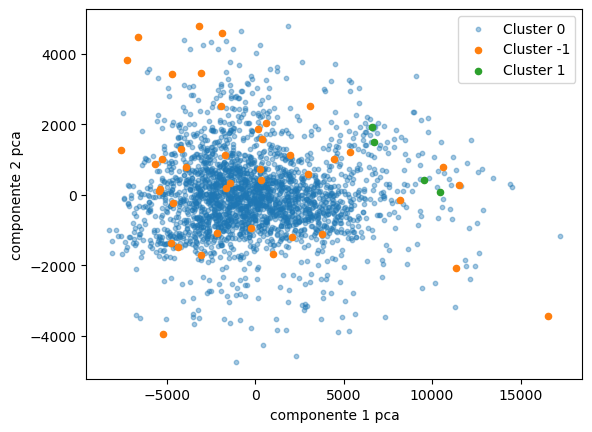

In [18]:
for label in labels[np.argsort(-sizes)]:
    if label == 0:
        plt.scatter(X_pca[dbscan.labels_ == label, 0], X_pca[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=10, alpha=0.4)
    else:
        plt.scatter(X_pca[dbscan.labels_ == label, 0], X_pca[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=20, alpha=1)
plt.xlabel('componente 1 pca')
plt.ylabel('componente 2 pca')        
plt.legend()
plt.show()

L'algoritmo sembra che stia riuscendo a individuare alcuni outliers. Tuttavia molti punti che dallo scatter plot potrebbero sembrare outlier non riesce a riconoscerli e altri punti invece sembrerebbe classificarli erroneamente come rumore (tuttavia il fatto che dal grafico non sembrino apparire come outliers potrebbe essere dovuto al fatto che necessariamente per ottenere una visualizzazione abbiamo fatto una proiezione su sole due dimensioni.)

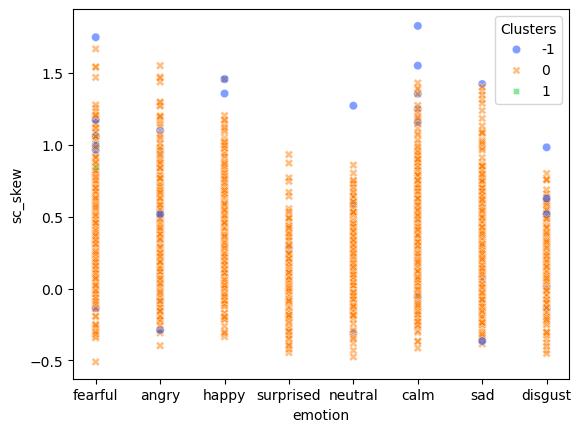

In [19]:
sns.scatterplot(data=original_df, x= 'emotion', y= "sc_skew", hue=dbscan.labels_, #"sc_kur", "sc_skew", stft_mean, "stft_kur"
                 style= dbscan.labels_, legend = "full", palette="bright", alpha = 0.5)

plt.legend(loc = 'upper right', title='Clusters')
plt.show()

Anche qui vediamo che l'algoritmo riesce ad assegnare alcuni outlier al cluster -1, ma non in modo particolarmente efficace.

In [20]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_train)

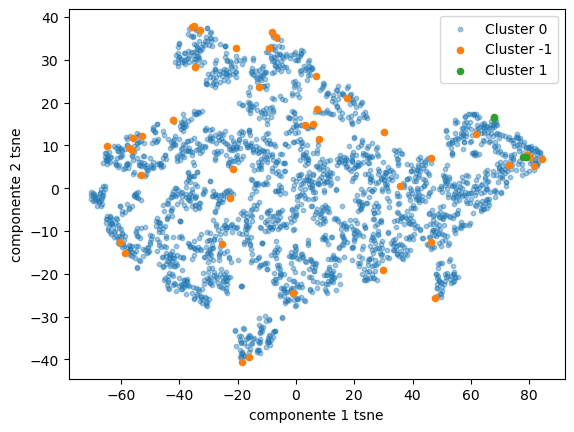

In [21]:
for label in labels[np.argsort(-sizes)]:
    if label == -1 or label == 1:
        plt.scatter(X_tsne[dbscan.labels_ == label, 0], X_tsne[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=20, alpha=1)
    else:
        plt.scatter(X_tsne[dbscan.labels_ == label, 0], X_tsne[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=10, alpha=0.4)
plt.xlabel('componente 1 tsne')
plt.ylabel('componente 2 tsne')        
plt.legend()
plt.show()

I punti del cluster -1 sono concentrati sul bordo come ci si potrebbe aspettare.

In [22]:
#dbscan = DBSCAN(min_samples=4, eps=0.208, metric='euclidean')
#dbscan = DBSCAN(min_samples=4, eps=0.23, metric='euclidean')
dbscan = DBSCAN(min_samples=4, eps=0.33, metric='euclidean')
dbscan.fit(train_data)

labels, sizes = np.unique(dbscan.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster -1, size 230 (0.09)
Cluster 0, size 2209 (0.90)
Cluster 1, size 10 (0.00)
Cluster 2, size 3 (0.00)


Quest'altro esempio di scelta dei parametri porta ad una situazione analoga alla precedente: oltre ai punti di rumore l'algoritmo riesce a generare solo tre cluster, di cui due però molto piccoli.
Anche provando altre configurazioni di parametri dbscan produce sempre un clustering con queste caratteristiche.

In [23]:
#df_train['dbscan_labels'] = dbscan.labels_

In [24]:
idx = dbscan.labels_ != -1
silhouette_score(D[idx][:, idx], dbscan.labels_[dbscan.labels_ != -1], metric='precomputed')

0.164606826406624

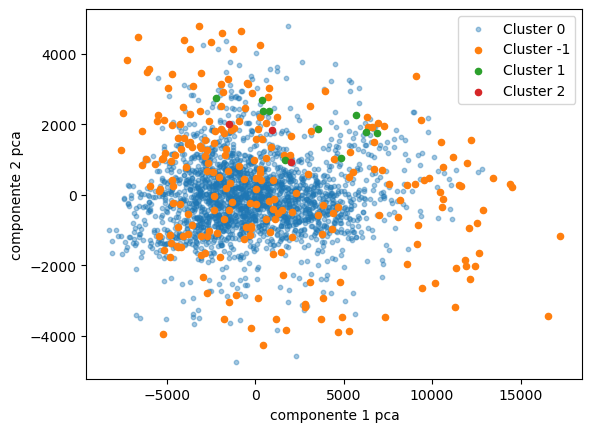

In [25]:
for label in labels[np.argsort(-sizes)]:
    if label == 0:
        plt.scatter(X_pca[dbscan.labels_ == label, 0], X_pca[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=10, alpha=0.4)
    else:
        plt.scatter(X_pca[dbscan.labels_ == label, 0], X_pca[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=20, alpha=1)
plt.xlabel('componente 1 pca')
plt.ylabel('componente 2 pca')
plt.legend()
plt.show()

In [26]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_train)

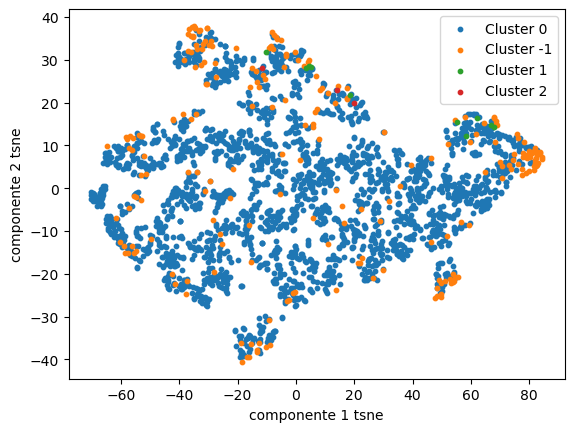

In [27]:
for label in labels[np.argsort(-sizes)]:
    plt.scatter(X_tsne[dbscan.labels_ == label, 0], X_tsne[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=10, alpha=1)
plt.legend()
plt.xlabel('componente 1 tsne')
plt.ylabel('componente 2 tsne')
plt.show()

L'algoritmo si comporta in modo molto simile alla configurazione di parametri precedente.

In [28]:
min_pts = 4
min_pts_distance = list()

for i in range(len(train_data)):
    neigh_idx = np.argsort(D[i])[min_pts]
    min_pts_distance.append(D[i, neigh_idx])

In [29]:
min_pts = 4
min_pts_distance = list()

for i in range(len(train_data)):
    neigh_idx = np.argsort(D[i])[min_pts]
    min_pts_distance.append(D[i, neigh_idx])

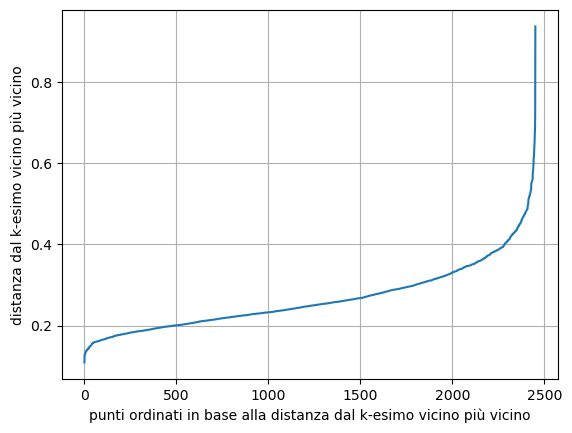

In [30]:
plt.plot(range(len(train_data)), sorted(min_pts_distance))
plt.grid()
plt.xlabel('punti ordinati in base alla distanza dal k-esimo vicino più vicino')
plt.ylabel('distanza dal k-esimo vicino più vicino')
plt.show()

Qui fissato k = min_points = 4, ho ordinato i punti del dataset per distanza crescente dal k-esimo punto più vicino e ho plottato questa distanza.
Questa curva può aiutare nella scelta dell'epsilon ed in particolare spiega perchè dato min_points = 4 e eps = 0.33 abbiamo trovato tanti punti di rumore (perché tutti i punti che corrispondono ad un'altezza della curva maggiore di 0.33 sono di bordo o rumore). Inoltre se volessimo usare "il metodo del ginocchio" questo ci porterebbe ad una scelta dell'epsilon uguala o vicina a quella che abbiamo ottenuto nel ciclo for cercando i parametri migliori.plt.plot(range(len(train_data)), sorted(min_pts_distance)).

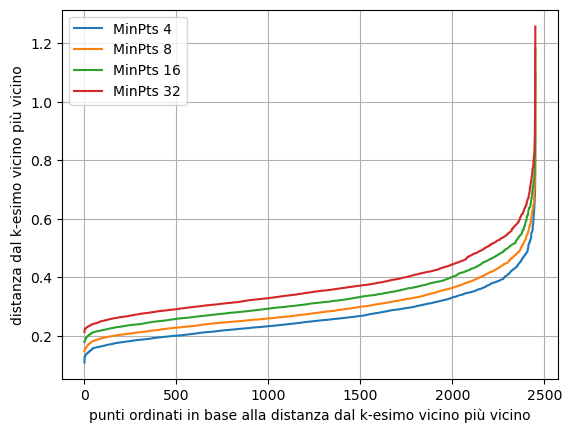

In [31]:
for min_pts in [4, 8, 16, 32]:
    min_pts_distance = list()

    for i in range(len(train_data)):
        neigh_idx = np.argsort(D[i])[min_pts]
        min_pts_distance.append(D[i, neigh_idx])

    plt.plot(range(len(train_data)), sorted(min_pts_distance), label='MinPts %s' % min_pts)
plt.grid()
plt.xlabel('punti ordinati in base alla distanza dal k-esimo vicino più vicino')
plt.ylabel('distanza dal k-esimo vicino più vicino')
plt.legend()
plt.show()

In questo grafico plotto le distanze dal k-esimo più vicino al variare di k=min_points.

# Normalizzazione delle distribuzioni

Proviamo a vedere come cambia il comportamento dell'algoritmo trasformando le variabili con QuantileTrasformer, di modo da avere distribuzioni normali, come abbiamo visto in precedenza nella data preparation.

In [32]:
qt = QuantileTransformer(output_distribution='normal')


In [33]:
df_train_norm = df_train.copy()

In [34]:
for column in df_train.columns:
    df_train_norm[column] = qt.fit_transform(df_train[[column]])

In [35]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train_norm)

In [36]:
df_train_norm2 = pd.DataFrame(train_data, columns = df_train_norm.columns)

In [37]:
D = squareform(pdist(train_data))

In [38]:
eps_list = np.arange(0.2, 0.5+0.01, 0.01)
min_samples_list = np.arange(4, 10+1, 1)
silhouette_list = list()

In [39]:
for min_samples in min_samples_list:
    temp_silhouette = list()
    for eps in eps_list:
        dbscan = DBSCAN(min_samples=min_samples, eps=eps, metric='euclidean')
        dbscan.fit(train_data)
        unique_labels = np.unique(dbscan.labels_)
        if len(unique_labels) > 2:
            idx = dbscan.labels_ != -1
            silhouette = silhouette_score(D[idx][:, idx], dbscan.labels_[idx], metric='precomputed')
            if np.isnan(silhouette):
                temp_silhouette.append(-2)
            else:
                temp_silhouette.append(silhouette)
        else:
            temp_silhouette.append(-2)
    silhouette_list.append(temp_silhouette)

In [40]:
silhouette_array = np.array(silhouette_list)
max_silhouette = np.amax(silhouette_array)
max_silhouette

0.3423707262699648

In [41]:
max_index = np.argmax(silhouette_array)
max_index_2d = np.unravel_index(max_index, silhouette_array.shape)
max_index_2d

(0, 6)

Cambiano i parametri con i quali si ottiene la silhouette migliore, che risulta più bassa di quella ottenuta senza trasformazione delle variabili. Cambiano i parametri con i quali si ottiene la silhouette migliore, che risulta più bassa di quella ottenuta senza trasformazione delle variabili. Tuttavia questo potrebbe non voler dire necessariamente che il clustering ottenuto sia di qualità inferiore. Adesso andiamo a verificare tramite dei plot l'efficacia di questo clustering.

In [42]:
dbscan = DBSCAN(min_samples=4, eps=0.2+6*0.01, metric='euclidean')
dbscan.fit(train_data)
idx = dbscan.labels_ != -1
silhouette_score(D[idx][:, idx], dbscan.labels_[idx], metric='precomputed')

0.3423707262699648

In [43]:
labels, sizes = np.unique(dbscan.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster -1, size 77 (0.03)
Cluster 0, size 2372 (0.97)
Cluster 1, size 3 (0.00)


La struttura del clustering è analoga alle precedenti, quindi la trasformazione delle variabili non sta aiutando dbscan a funzionare meglio.

In [44]:
pca = PCA(n_components=2)

In [45]:
pca.fit(df_train_norm2)

PCA(n_components=2)

In [46]:
X_pca = pca.transform(df_train_norm2)

In [47]:
pca.explained_variance_ratio_

array([0.32311366, 0.18992222])

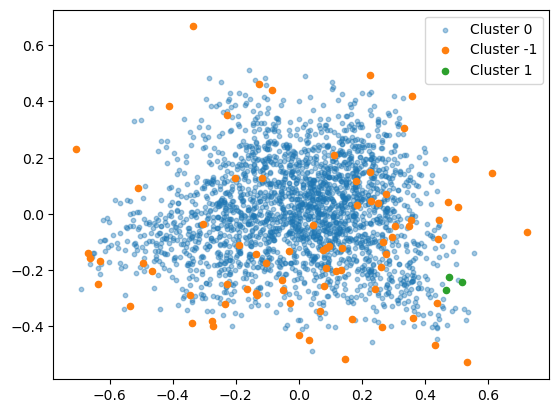

In [48]:
for label in labels[np.argsort(-sizes)]:
    if label == 0:
        plt.scatter(X_pca[dbscan.labels_ == label, 0], X_pca[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=10, alpha=0.4)
    else:
        plt.scatter(X_pca[dbscan.labels_ == label, 0], X_pca[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=20, alpha=1)
plt.legend()
plt.show()

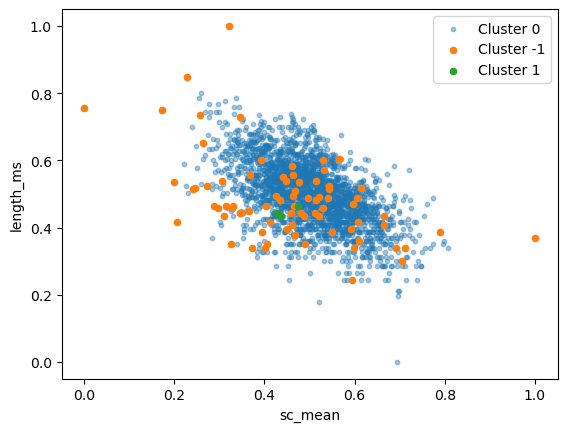

In [49]:
for label in labels[np.argsort(-sizes)]:
    if label == 0:
        plt.scatter(df_train_norm2.loc[dbscan.labels_ == label,'sc_mean'], df_train_norm2.loc[dbscan.labels_ == label,'length_ms'], label=f'Cluster {label}', s=10, alpha=0.4)
    else:
        plt.scatter(df_train_norm2.loc[dbscan.labels_ == label,'sc_mean'], df_train_norm2.loc[dbscan.labels_ == label,'length_ms'], label=f'Cluster {label}', s=20, alpha=1)
plt.legend()
plt.xlabel('sc_mean')
plt.ylabel('length_ms')
plt.show()

Qui abbiamo fatto lo scatter plot delle variabili sc_mean e length_ms e si osserva sempre che il dbscan riesce a catturare qualche outlier.

In [50]:
df_train_norm3 = df_train_norm2.copy()
df_train_norm3['emotion'] = original_df['emotion']

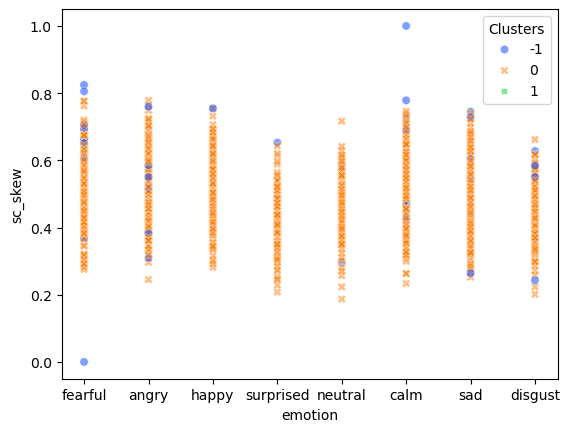

In [51]:
sns.scatterplot(data=df_train_norm3, x= 'emotion', y= "sc_skew", hue=dbscan.labels_, #"sc_kur", "sc_skew", stft_mean, "stft_kur"
                 style= dbscan.labels_, legend = "full", palette="bright", alpha = 0.5)

plt.legend(loc = 'upper right', title='Clusters')
plt.show()

In [52]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_train_norm2)

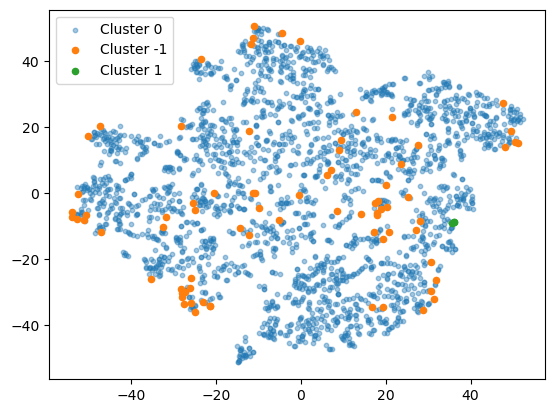

In [53]:
for label in labels[np.argsort(-sizes)]:
    if label == -1 or label == 1:
        plt.scatter(X_tsne[dbscan.labels_ == label, 0], X_tsne[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=20, alpha=1)
    else:
        plt.scatter(X_tsne[dbscan.labels_ == label, 0], X_tsne[dbscan.labels_ == label, 1], label=f'Cluster {label}', s=10, alpha=0.4)
plt.legend()
plt.show()

Per questi scatter plot valgono le stesse considerazioni fatte in precedenza.

In definitiva possiamo concludere che con questo dataset l'algoritmo dbscan si comporta particolarmente male, questo potrebbe essere dovuto al fatto che la struttura 'geometrica' del dataset non sembra essere compatibile con le configurazioni in cui il dbscan funziona meglio, ovvero dataset formati da regioni dense di punti separate da regioni a bassa densità.

# Hierarchical clustering

Si procede alla clusterirrazione gerarchica del dataframe eseguendo tecniche agglomerative prima con la relativa libreria di scipy e poi con quella di sklearn. 

La clusterizzazione si esegue sul dataframe normalizzato con metodo MinMax Scaler.

Nella parte conclusiva si tenta un commento sui risultati ottenuti.

In [54]:
df = pd.read_csv('ravdess_features_base.csv')

In [55]:
df_original = df.copy()

In [56]:
df.isnull().sum()

Unnamed: 0             0
length_ms              0
zero_crossings_sum     0
std                    0
kur                    0
skew                   0
mfcc_mean              0
mfcc_std               0
mfcc_max               0
sc_mean                0
sc_std                 0
sc_min                 0
sc_max                 0
sc_kur                 0
sc_skew                0
stft_std               0
stft_min               0
stft_kur               0
stft_skew              0
vocal_channel          0
emotion                0
emotional_intensity    0
statement              0
repetition             0
sex                    0
dtype: int64

In [57]:
df.dtypes

Unnamed: 0               int64
length_ms                int64
zero_crossings_sum       int64
std                    float64
kur                    float64
skew                   float64
mfcc_mean              float64
mfcc_std               float64
mfcc_max               float64
sc_mean                float64
sc_std                 float64
sc_min                 float64
sc_max                 float64
sc_kur                 float64
sc_skew                float64
stft_std               float64
stft_min               float64
stft_kur               float64
stft_skew              float64
vocal_channel           object
emotion                 object
emotional_intensity     object
statement               object
repetition              object
sex                     object
dtype: object

Pre-processing per la preparazione del dataset alla clusterizzazione gerarchica. 

Poiché il clustering gerarchico è un metodo basato sulle distanze, si ritiene necessario normalizzare tutte le features continue. Tra StandardScaler e MinMax, si procede su quest'ultimo.  

In [58]:
cat_columns = ['Unnamed: 0', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'vocal_channel'] 
df_hier = df.drop(cat_columns, axis = 1)

In [59]:
scaler = MinMaxScaler()
scaler.fit(df_hier)

MinMaxScaler()

In [60]:
norm_df_hier = scaler.transform(df_hier)

In [61]:
norm_df_hier = scaler.transform(df_hier)

In [62]:
Ds = pdist(norm_df_hier) #calcolo distanze

#### HIERARCHYCAL CLUSTERIG CON scipy.cluster.hierarchy

#### SINGLE LINKAGE

In [63]:
links = linkage(Ds, method = 'single') #con single-linkage, linkage gestisce la parte agglomerativa

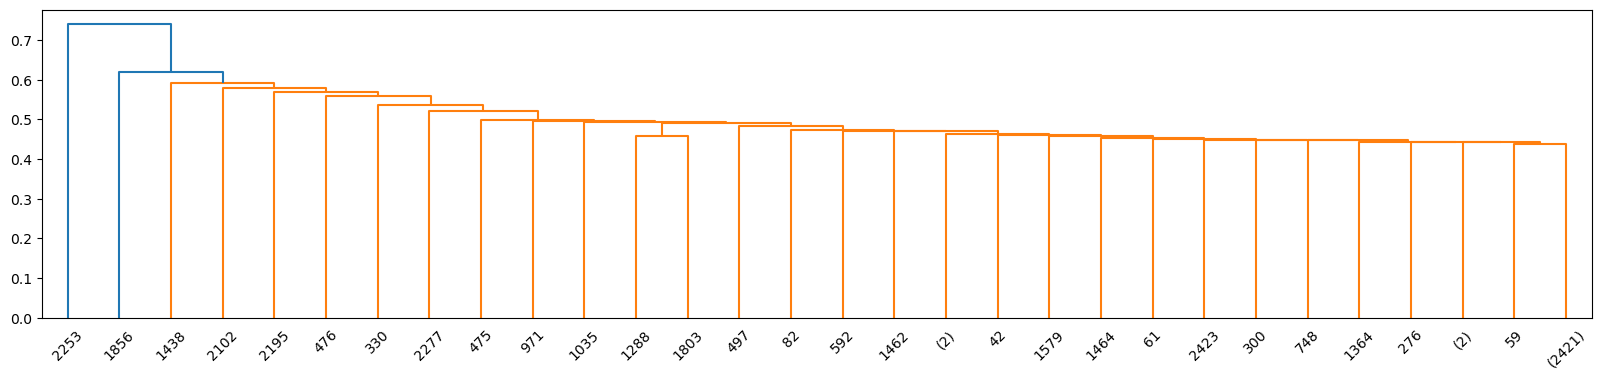

In [64]:
plt.figure(figsize = (20,4)) #dendrogram per visualizzazione, lastp la rende leggibile
den = dendrogram (links, truncate_mode = 'lastp', color_threshold = 0.6) #lastp sceglie cosa farci vedere

Si scrive un ciclo for per capire quale è il troncamento miglore in base al livello del dendrogramma

In [65]:
trunc_levels = np.arange(0.0, 0.8, 0.1)
links = linkage(Ds, method = 'single')
list_sils = []

for t in trunc_levels:
    label = fcluster(links,
                     t=t,
                     criterion = 'distance')
    sil_s = silhouette_score(norm_df_hier, label)
    list_sils.append(sil_s)

    print(f't= {t}, Silhouette Score= {sil_s}')

t= 0.0, Silhouette Score= 0.0008156606851549756
t= 0.1, Silhouette Score= 0.007767699886894586
t= 0.2, Silhouette Score= -0.16919253573813797
t= 0.30000000000000004, Silhouette Score= -0.32370486859368375
t= 0.4, Silhouette Score= -0.20612797221251017
t= 0.5, Silhouette Score= 0.10689780486935752
t= 0.6000000000000001, Silhouette Score= 0.24711678245837052
t= 0.7000000000000001, Silhouette Score= 0.5451646499049196


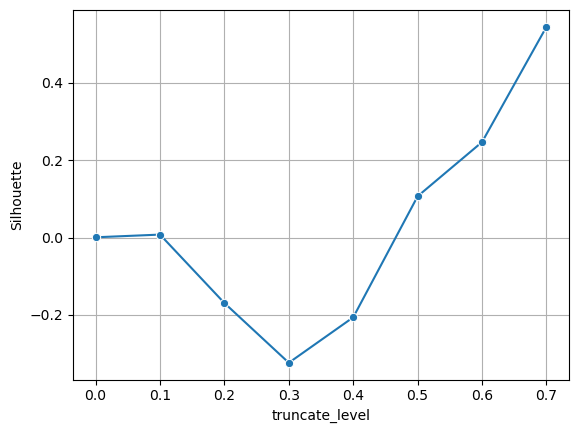

In [66]:
sns.lineplot(x=trunc_levels, y=list_sils, marker='o')
plt.ylabel('Silhouette')
plt.xlabel('truncate_level')
plt.xticks(list(trunc_levels))
plt.grid(True)
plt.show()

Il livello migliore sembra essere lo 0.6, che dà un silhouette score di 0.24. Il valore più alto è ovviamente 0.5, 
ma non si può considerare poiché a quel livello verrebbe fuori solamente un grande cluster. Tuttavia, neanche il livello  0.6 rappresenta una buona opzione, poiché in questo caso viene prodotto in grande cluster (quello in arancione) con la  maggioranza dei punti, e poi due singletons. Per questo, sebbene la silhouette sia solo di 0.10, si effettua il taglio al livello 0.5 e poi si verifica quale è il numero effettivo dei punti che andranno a comporre i cluster che ne risultano.

In [67]:
sing_labels = fcluster(links, t= 0.5, criterion = 'distance')
sing_labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [68]:
unique_clusters, counts = np.unique(sing_labels, return_counts = True)
cluster_counts = dict(zip(unique_clusters, counts))
cluster_counts

{1: 2444, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}

Come si nota da questo dizionario,il single linkage non rappresenta assolutamente un buon metodo per la clusterizzazione gerarchica. 
Pur compromettendo il silhouette score, non si arriva all'individuazione di cluster che siano effettivamente significativi. Sebene i cluster siano 
9, ben 8 sono singletons, mentre 1 contiene tutti gli altir punti. Probabilmente l'unica cosa significativa di questo modello è che i punti singleton possono essere considerati come outliers. 

In [69]:
sing_sil_score = silhouette_score(norm_df_hier, sing_labels)
sing_sil_score

0.10689780486935752

In [70]:
a = sing_sil_score

Sebbene visti i risultati del metodo single linkage non abbia molto senso, si individuano e plottano i centrodidi.

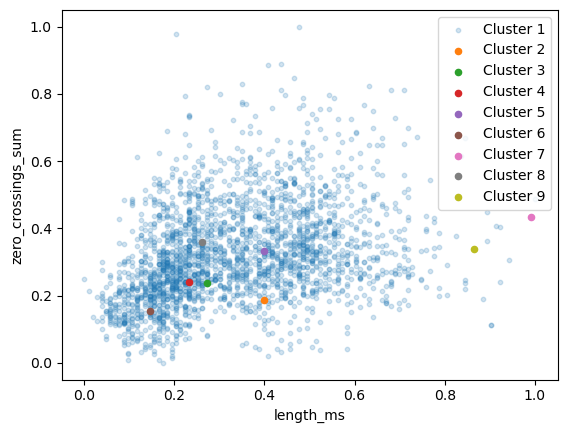

In [71]:
for label in unique_clusters[np.argsort(-counts)]:
    if label == 1:
        plt.scatter(norm_df_hier[sing_labels == label, 0], norm_df_hier[sing_labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.2)
    else:
        plt.scatter(norm_df_hier[sing_labels == label, 0], norm_df_hier[sing_labels == label, 1], label=f'Cluster {label}', s=20, alpha=1)
plt.legend()
plt.xlabel(df_hier.columns[0])
plt.ylabel(df_hier.columns[1])
plt.show()

Contrariamente rispetto a quanto speravamo l'algoritmo non sembra riuscire a catturare nemmeno gli outliers (almeno rispetto a queste due variabili).

In [72]:
sing_centers = list()
for l in sorted(np.unique(sing_labels)):
    sing_centers.append(np.mean(norm_df_hier[sing_labels == l], axis = 0))
sing_centers = np.array(sing_centers)

In [73]:
df_com_cent = pd.DataFrame(data = sing_centers, columns = df_hier.columns)

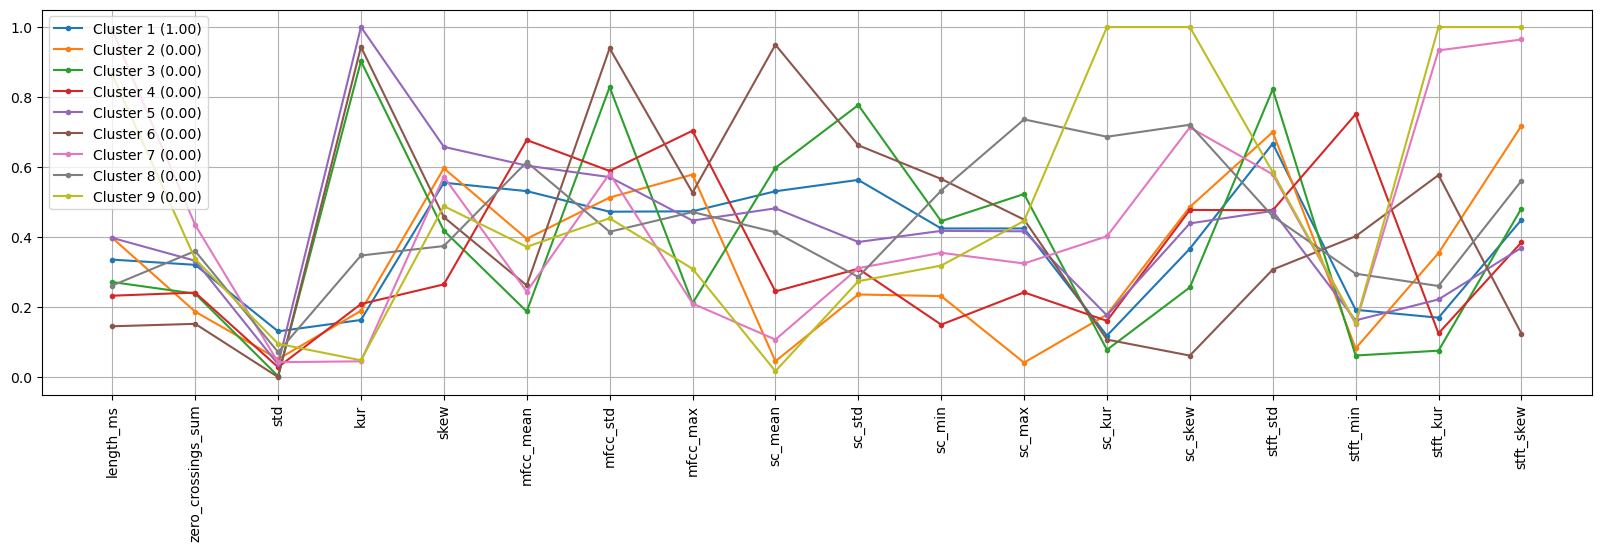

In [74]:
labels, sizes = np.unique(sing_labels, return_counts = True)
plt.figure(figsize = (20,5))

for l in np.unique(sing_labels):
    plt.plot(df_com_cent.columns, sing_centers[l-1], marker = '.', label = 'Cluster %s (%.2f)' % (l, sizes[l-1]/len(norm_df_hier)))

plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

Questo plot, per quanto carino, non è per niente significativo coniderando l'abbondanza di singleton nella clusterizzazione.

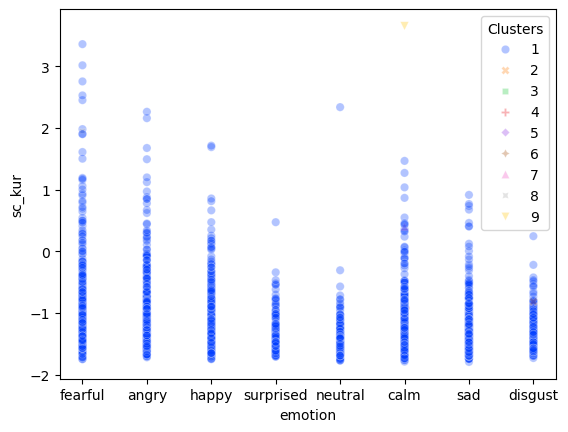

In [75]:
sns.scatterplot(data=df_original, x= "emotion", y= "sc_kur", hue=sing_labels, 
                style= sing_labels, legend = "full", palette="bright", alpha = 0.3)

plt.legend(loc = 'upper right', title='Clusters')
plt.show()

Questo scatter-plot, conferma che il numero di punti più grande è costituito dal cluster 1 e il fatto che non riesce ad individuare bene gli outliers.  

Concludiamo notando che in realtà il cattivo funzionamento di single linkage non sorprende visto che è un algoritmo molto semsibile alla presenza di outliers e il nostro daset ne è ricco.

#### COMPLETE LINKAGE

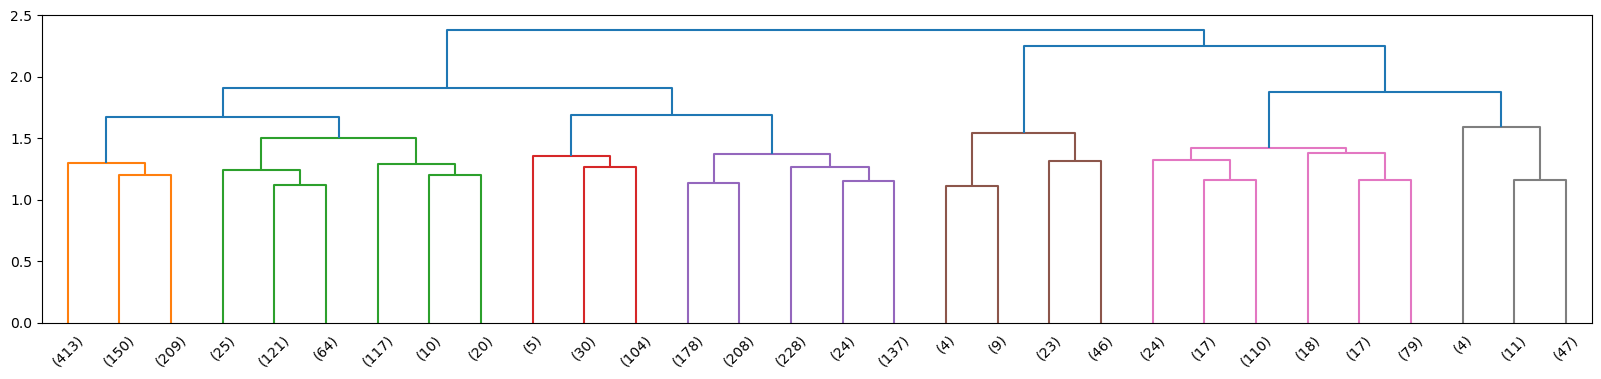

In [76]:
links_com = linkage(Ds, method = 'complete')
plt.figure(figsize = (20,4))
den_com = dendrogram(links_com, truncate_mode = 'lastp')

In [77]:
trunc_levels = np.arange(0.0, 2.5, 0.5)
links = linkage(Ds, method = 'complete')
list_sils = []
for t in trunc_levels:
    label = fcluster(links,
                     t=t,
                     criterion = 'distance')
    sil_s = silhouette_score(norm_df_hier, label)
    list_sils.append(sil_s)

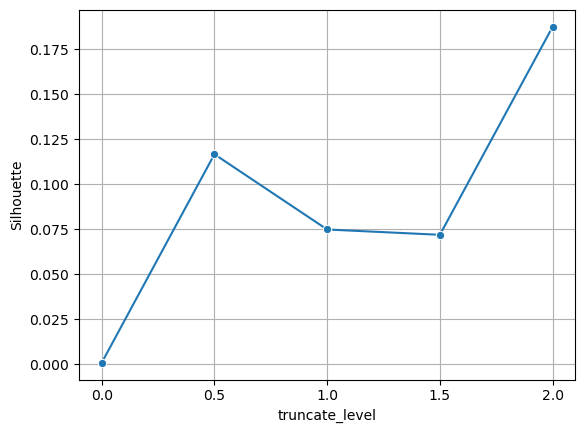

In [78]:
sns.lineplot(x=trunc_levels, y=list_sils, marker='o')
plt.ylabel('Silhouette')
plt.xlabel('truncate_level')
plt.xticks(list(trunc_levels))
plt.grid(True)
plt.show()

Il risultato di questo ciclo ci dice che il trocamento migliore avviene a livello 2.0.

In [79]:
com_labels = fcluster(links_com, t= 2, criterion = 'distance')
com_labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [80]:
unique_clusters, counts = np.unique(com_labels, return_counts = True)
cluster_counts = dict(zip(unique_clusters, counts))
cluster_counts

{1: 2043, 2: 82, 3: 327}

Questo risultato, sebbene comunque per niente ideale (soprattutto in termini di silhouette score), porta a una clusterizzazione più
significativa, poiché i punti del dataset sono più ripartiti tra i tre cluster che ne vengono fuori.

In [81]:
com_sil_score = silhouette_score(norm_df_hier, com_labels)
com_sil_score

0.18735368785465042

In [82]:
a1 = com_sil_score

In [83]:
unique_clusters[np.argsort(-counts)]

array([1, 3, 2], dtype=int32)

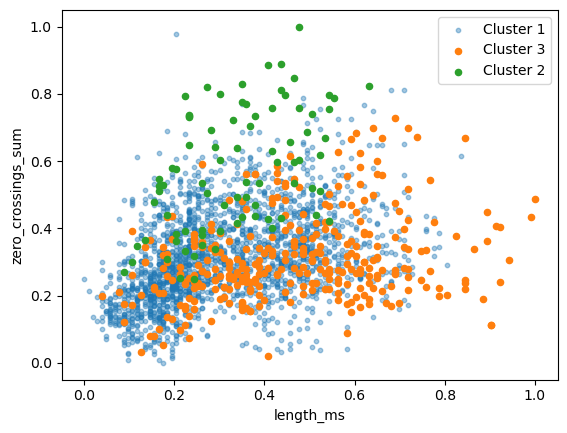

In [84]:
for label in unique_clusters[np.argsort(-counts)]:
    if label == 1:
        plt.scatter(norm_df_hier[com_labels == label, 0], norm_df_hier[com_labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.4)
    else:
        plt.scatter(norm_df_hier[com_labels == label, 0], norm_df_hier[com_labels == label, 1], label=f'Cluster {label}', s=20, alpha=1)
plt.legend()
plt.xlabel(df_hier.columns[0])
plt.ylabel(df_hier.columns[1])
plt.show()

Sebbene i cluster da questa visualizzazione sembrino ancora sovrapposti, notiamo una certa separazione tra il cluster 2 e il cluster 3.

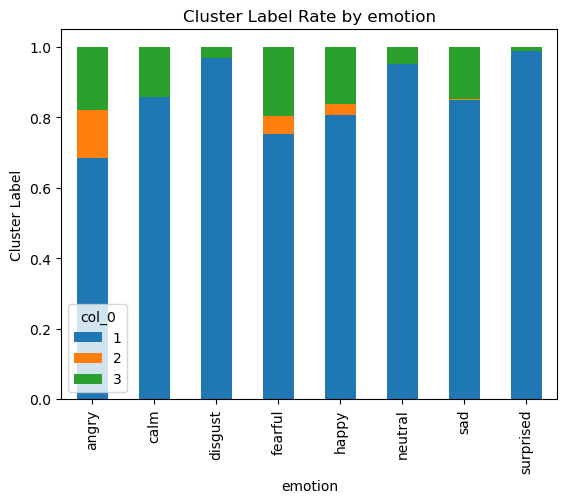

In [85]:
emotion_xt = pd.crosstab(df['emotion'], com_labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('emotion')
plt.ylabel('Cluster Label')
plt.show()

E' interessante notare come i record corrispondenti all'emozione surprised siano tutti contenuti nel cluster 1, il cluster 2 contiene solamente quelli con emozione angry, fearful e happy. Quindi questo clustering forse sta riuscendo a catturare qualche caratteristica interessente del nostro dataset.

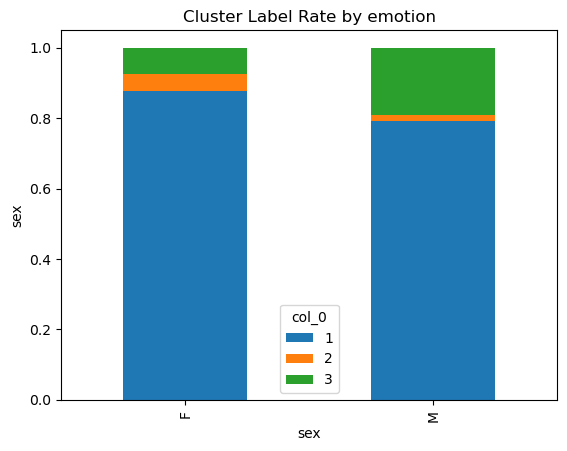

In [86]:
emotion_xt = pd.crosstab(df['sex'], com_labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('sex')
plt.ylabel('sex')
plt.show()

Rispetto alla variabile sex questo clustering non sembra riuscire a separare bene i record.

In [87]:
com_centers = list()
for l in sorted(np.unique(com_labels)):
    com_centers.append(np.mean(norm_df_hier[com_labels == l], axis = 0))
com_centers = np.array(com_centers)

In [88]:
df_s_c = pd.DataFrame(data = com_centers, columns = df_hier.columns)

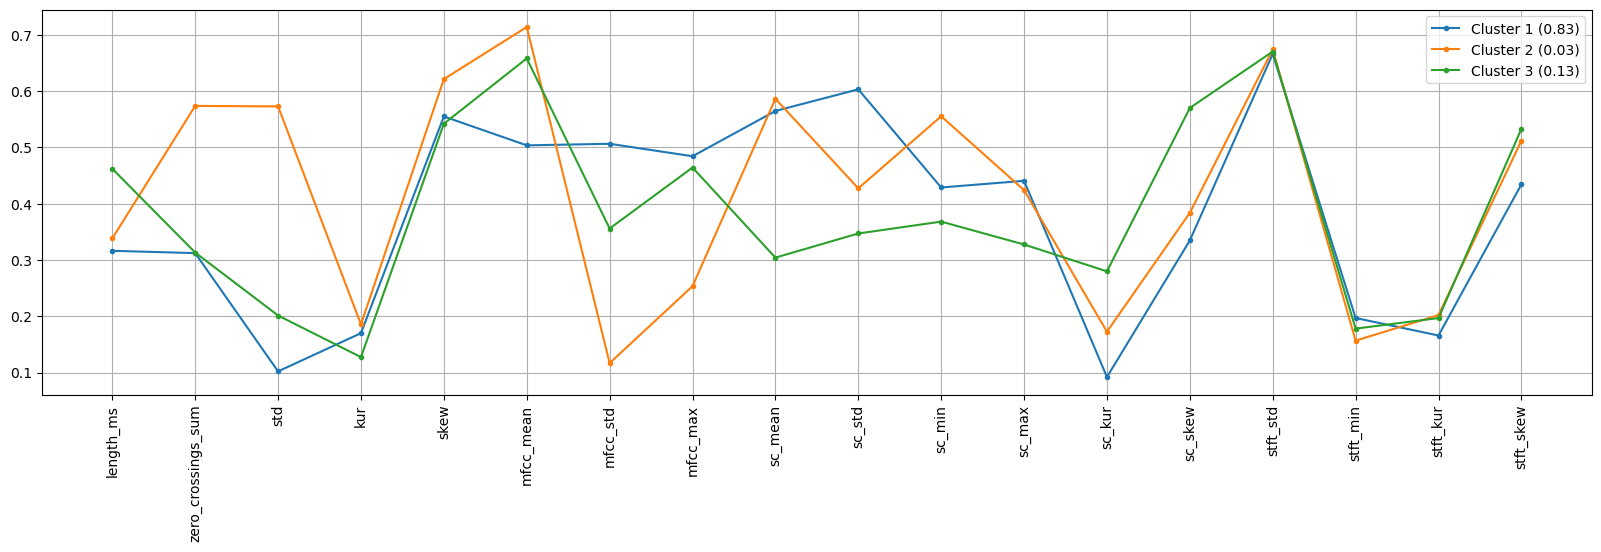

In [89]:
labels, sizes = np.unique(com_labels, return_counts = True)
plt.figure(figsize = (20,5))

for l in np.unique(com_labels):
    plt.plot(df_s_c.columns, com_centers[l-1], marker = '.', label = 'Cluster %s (%.2f)' % (l, sizes[l-1]/len(norm_df_hier)))

plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

Questo plot conferma la nostra impressione di una migliore sepazione tra i cluster 2 e 3 in length_ms e zero_crossings_sum. Quindi in generale questo grafico ci suggerisce rispetto a quali variabili i cluster sono più separati.

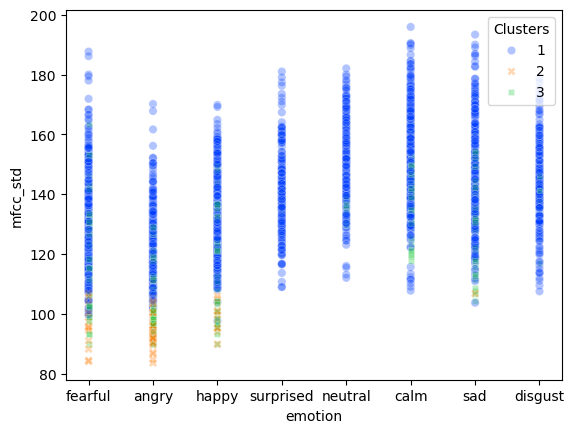

In [90]:
sns.scatterplot(data=df_original, x= "emotion", y= "mfcc_std", hue=com_labels, 
                style= com_labels, legend = "full", palette="bright", alpha = 0.3)

plt.legend(loc = 'upper right', title='Clusters')
plt.show()

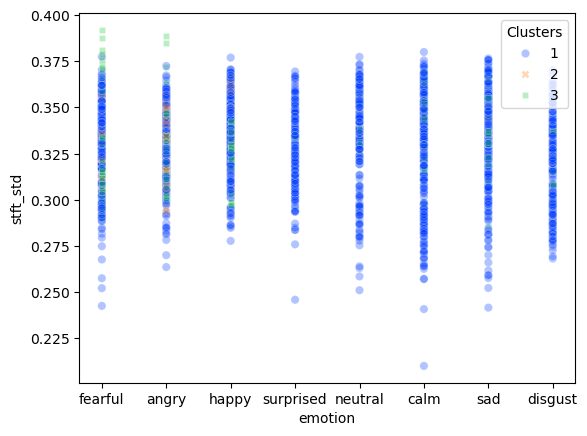

In [91]:
sns.scatterplot(data=df_original, x= 'emotion', y= "stft_std", hue=com_labels, 
                style= com_labels, legend = "full", palette="bright", alpha = 0.3)

plt.legend(loc = 'upper right', title='Clusters')
plt.show()

Con questi scatter-plot possiamo osservare la distribuzione dei cluster rispetto a due variabili di riferimento nei dati originali. 

In particolare, nel primo scatter-plot si considera la feature emotion in relazione a una feature (mfcc_std) i cui centrodi sono ben distanziati 
(proprio come si vede nel plot dei centroidi). Questo porta a uno scatter-plot in cui la ripartizione dei cluster è abbastanza delineata. 

Il secondo scatter-plot è condotto su emotion e stft_std, i cui centrodi sono più accavallati. Questa porta a una ripartizione più fuzzy
dei cluster, come si vede nella grafica. 

#### AVERAGE LINKAGE

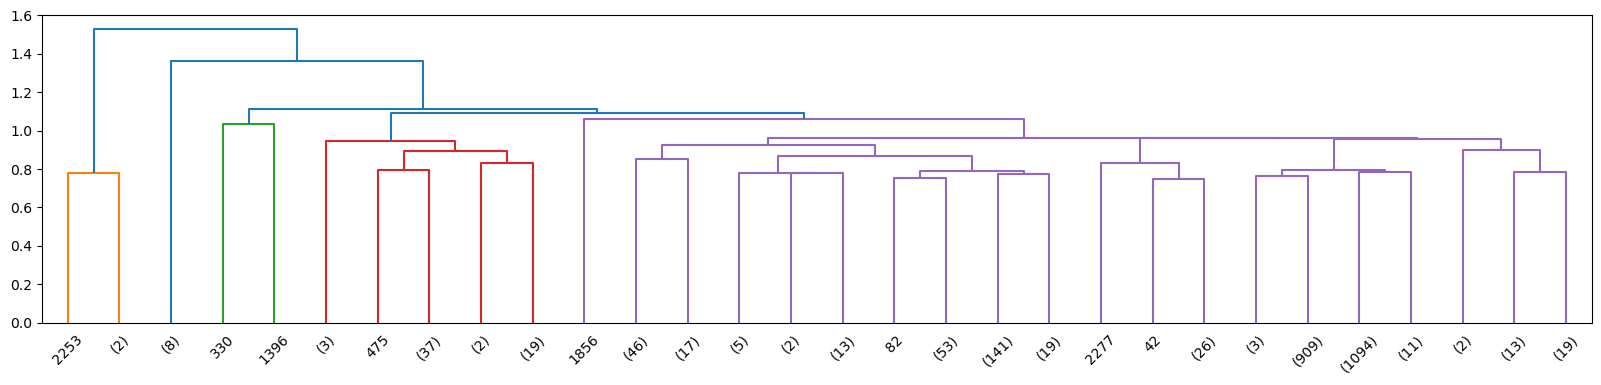

In [92]:
links_avg = linkage(Ds, method = 'average')
plt.figure(figsize = (20,4))
den_avg = dendrogram(links_avg, truncate_mode = 'lastp')

In [93]:
trunc_levels = np.arange(0.0, 1.6, 0.2)
links = linkage(Ds, method = 'average')
list_sils = []
for t in trunc_levels:
    label = fcluster(links,
                     t=t,
                     criterion = 'distance')
    sil_s = silhouette_score(norm_df_hier, label)
    list_sils.append(sil_s)

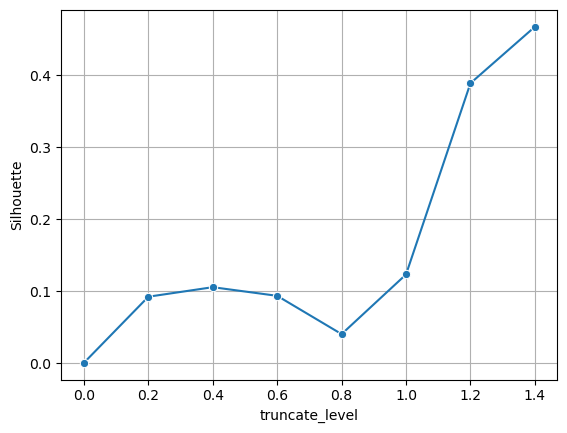

In [94]:
sns.lineplot(x=trunc_levels, y=list_sils, marker='o')
plt.ylabel('Silhouette')
plt.xlabel('truncate_level')
plt.xticks(list(trunc_levels))
plt.grid(True)
plt.show()

Il fatto che il risultato di silhouette migliore si otterrebbe effettuando il taglio al livello 1.2 non deve trarre in inganno: infatti, in quel caso si avrebbe
un mega-cluster con tutti i punti del dataset e un altro con solo due. Per questo, sebbene la silhouette sia inferiore, procediamo col taglio al livello 1.0

In [95]:
avg_labels = fcluster(links_avg, t= 1.0, criterion = 'distance')
avg_labels

array([6, 6, 6, ..., 6, 6, 6], dtype=int32)

In [96]:
unique_clusters, counts = np.unique(avg_labels, return_counts = True)
cluster_counts = dict(zip(unique_clusters, counts))
cluster_counts

{1: 3, 2: 8, 3: 1, 4: 1, 5: 62, 6: 2376, 7: 1}

Il taglio più in basso, non porta a una clusterizzazione soddisfacente, come mostra il dizionario, in cui si vede chiaramente
che il cluster 6 ha la maggiorparte dei punti. 

In [97]:
avg_sil_score = silhouette_score(norm_df_hier, avg_labels)
avg_sil_score

0.1233246427239758

In [98]:
a2 = avg_sil_score

In [99]:
unique_clusters[np.argsort(-counts)]

array([6, 5, 2, 1, 3, 4, 7], dtype=int32)

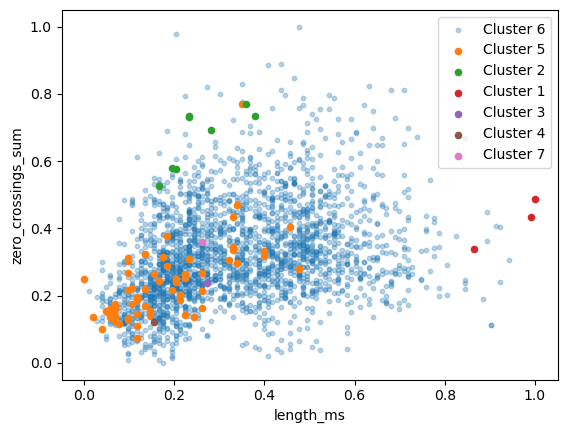

In [100]:
for label in unique_clusters[np.argsort(-counts)]:
    if label == 6:
        plt.scatter(norm_df_hier[avg_labels == label, 0], norm_df_hier[avg_labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.3)
    else:
        plt.scatter(norm_df_hier[avg_labels == label, 0], norm_df_hier[avg_labels == label, 1], label=f'Cluster {label}', s=20, alpha=1)
plt.legend()
plt.xlabel(df_hier.columns[0])
plt.ylabel(df_hier.columns[1])
plt.show()

Anche in questo caso l'algoritmo non sembra funzionare particolarmente bene e la ripartizione dei punti nei vari cluster rimane molto sbilanciata. 

In [101]:
#calcolo dei centroidi 
avg_centers = list()
for l in sorted(np.unique(avg_labels )):
    avg_centers.append(np.mean(norm_df_hier[avg_labels == l], axis = 0))
avg_centers = np.array(avg_centers)

In [102]:
df_avg_c = pd.DataFrame(data = avg_centers, columns = df_hier.columns)

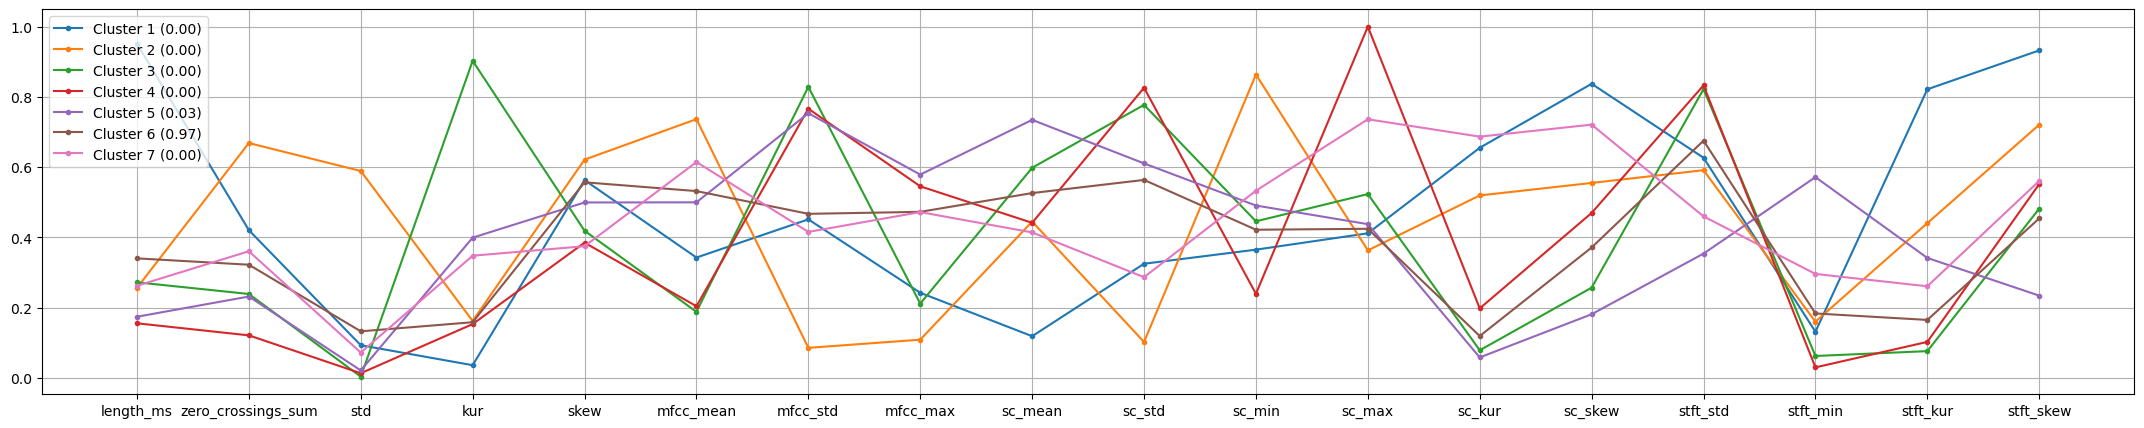

In [103]:
#plottare i centroidi 

labels, sizes = np.unique(avg_labels, return_counts = True)
plt.figure(figsize = (27,5))

for l in np.unique(avg_labels):
    plt.plot(df_avg_c.columns, avg_centers[l-1], marker = '.', label = 'Cluster %s (%.2f)' % (l, sizes[l-1]/len(norm_df_hier)))

plt.grid()
plt.legend()
plt.show()
    

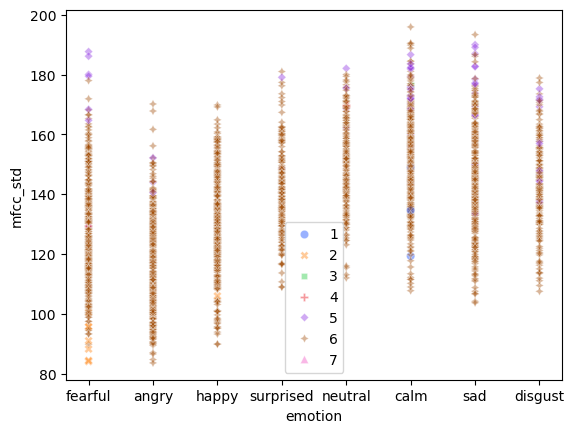

In [104]:
sns.scatterplot(data=df_original, x= "emotion", y= "mfcc_std", hue=avg_labels, 
                style=avg_labels, palette="bright", alpha = 0.4)
plt.show()

Questo scatter-plot si basa su una feature cone mfcc_std in cui la distanza dei centroidi sembra più significativa. Questo si riverbera nello scatter-plot
soprattutto al livello delle emotion fearful e sad, nel cui livello superiore si rivela la presenza dei punti del cluster 5, cosa notevole vista la piccola dimensione del cluster 5 rispetto al 6. 
Ovviamente, considerando lo sbilanciamento del numero di punti nei vari cluster, questo scatter plot ci dice molto poco.

#### WARD METHOD 

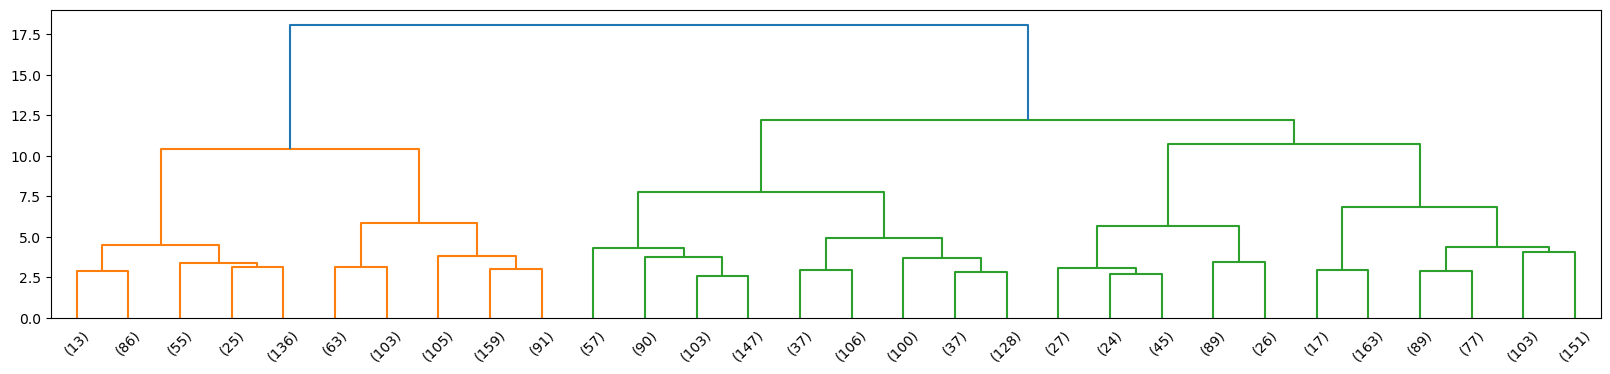

In [105]:
links_w = linkage(Ds, method = 'ward')
plt.figure(figsize = (20,4))
den_avg = dendrogram(links_w, truncate_mode = 'lastp')

In [106]:
trunc_levels = np.arange(0.0, 17.5, 0.5)
links = linkage(Ds, method = 'ward')
list_sils = []
for t in trunc_levels:
    label = fcluster(links,
                     t=t,
                     criterion = 'distance')
    sil_s = silhouette_score(norm_df_hier, label)
    list_sils.append(sil_s)

In questo caso il troncamento migliore va effettuato al livello 12.0

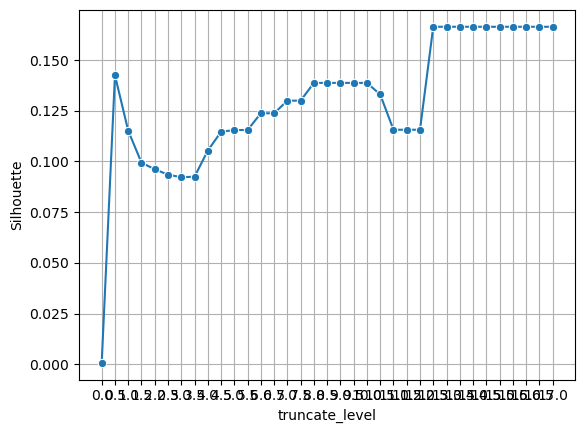

In [107]:
sns.lineplot(x=trunc_levels, y=list_sils, marker='o')
plt.ylabel('Silhouette')
plt.xlabel('truncate_level')
plt.xticks(list(trunc_levels))
plt.grid(True)
plt.show()

In [108]:
w_labels = fcluster(links_w, t= 12.0, criterion = 'distance')
w_sil_score = silhouette_score(norm_df_hier, w_labels)
w_sil_score

0.11562485177986392

In [109]:
unique_clusters, counts = np.unique(w_labels, return_counts = True)
cluster_counts = dict(zip(unique_clusters, counts))
cluster_counts

{1: 836, 2: 805, 3: 811}

Il metodo ward dà un silhouette coefficient più alto laddove il taglio si esegue al livello 12, producendo tre clusters ben ripartiti. 
Il risultato, quindi sembra molto più significativo del caso dei metodi single e average.

In [110]:
a3 = w_sil_score

In [111]:
unique_clusters[np.argsort(-counts)]

array([1, 3, 2], dtype=int32)

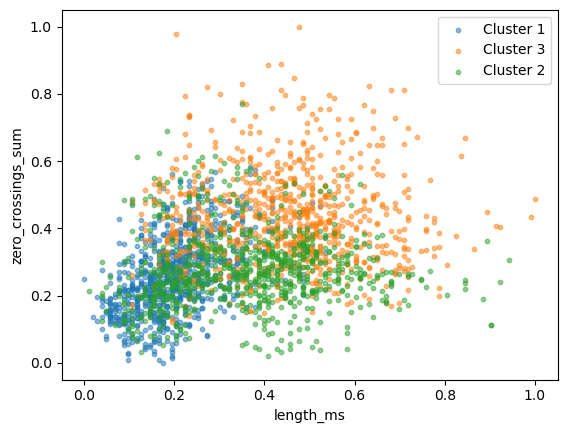

In [112]:
for label in unique_clusters[np.argsort(-counts)]:
    if label == 1:
        plt.scatter(norm_df_hier[w_labels == label, 0], norm_df_hier[w_labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.5)
    else:
        plt.scatter(norm_df_hier[w_labels == label, 0], norm_df_hier[w_labels == label, 1], label=f'Cluster {label}', s=10, alpha=0.5)
plt.legend()
plt.xlabel(df_hier.columns[0])
plt.ylabel(df_hier.columns[1])
plt.show()

I cluster 2 e 3 sembrano abbastanza separati, quindi a livello di questa visualizzazione fino ad adesso il ward sembra il migliore.

In [113]:
w_centers = list()
for l in sorted(np.unique(w_labels )):
    w_centers.append(np.mean(df_hier[w_labels == l], axis = 0))
w_centers = np.array(w_centers)

In [114]:
df_w_c = pd.DataFrame(data = w_centers, columns = df_hier.columns)

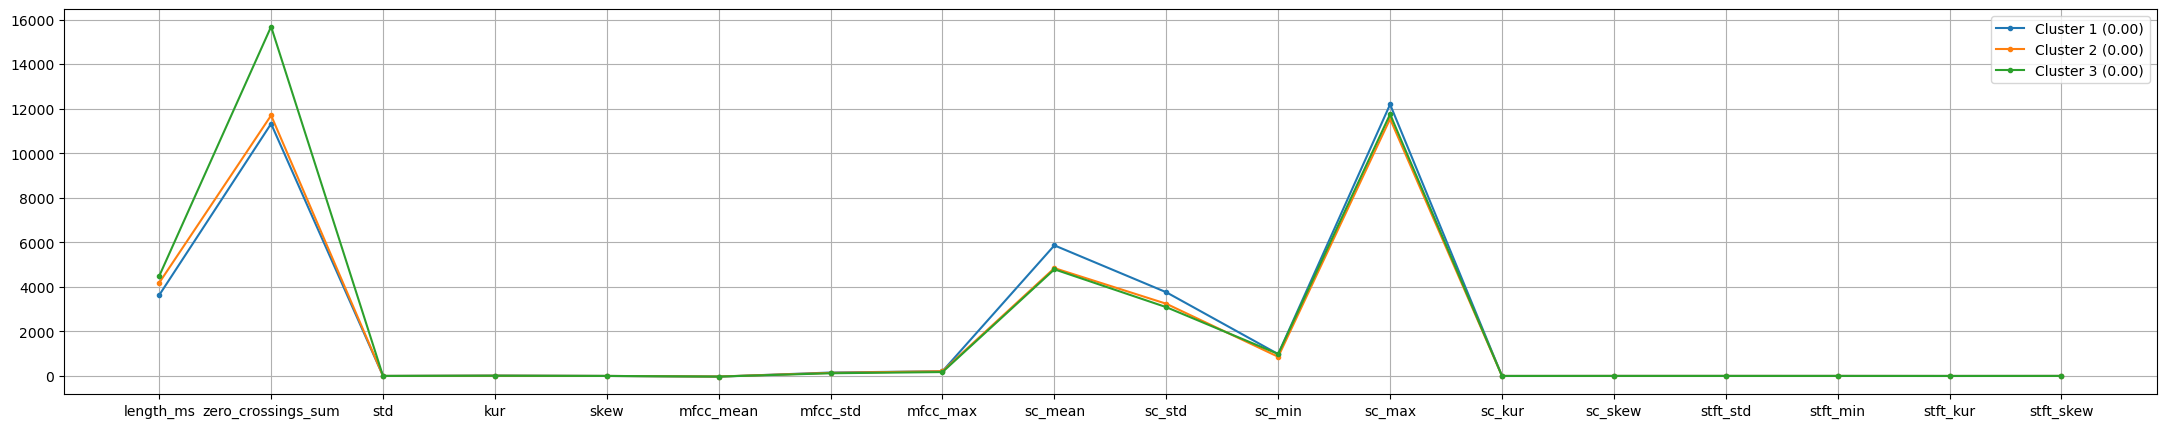

In [115]:
labels, sizes = np.unique(w_centers, return_counts = True)
plt.figure(figsize = (27,5))

for l in np.unique(w_labels):
    plt.plot(df_w_c.columns, w_centers[l-1], marker = '.', label = 'Cluster %s (%.2f)' % (l, sizes[l-1]/len(norm_df_hier)))

plt.grid()
plt.legend()
plt.show()
    

In realtà da questo grafico si vede che per la maggior parte delle variabili i centroidi dei cluster sono molto vicini.

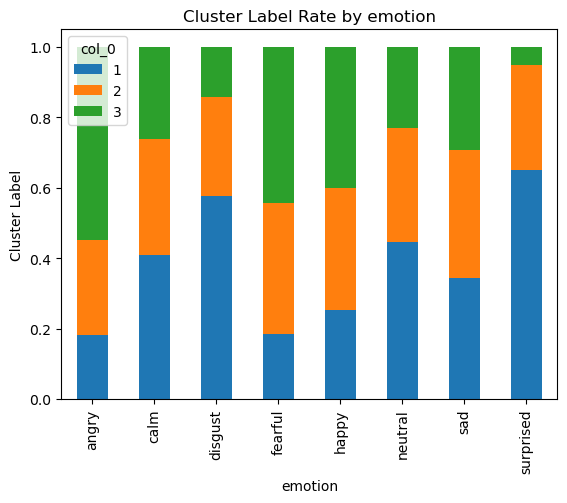

In [116]:
emotion_xt = pd.crosstab(df['emotion'], w_labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('emotion')
plt.ylabel('Cluster Label')
plt.show()

Questo clustering non sembra in grado di separare bene i record rispetto a emotion.

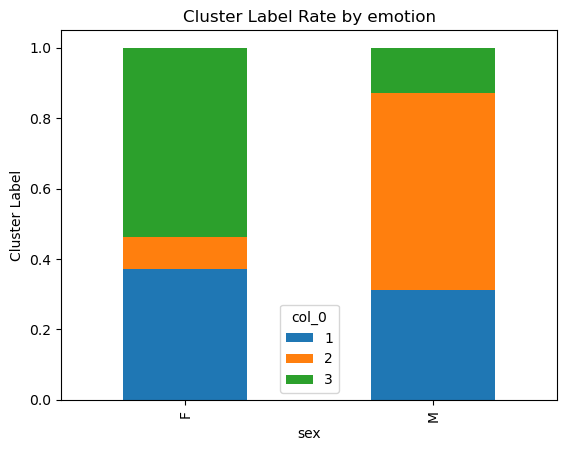

In [117]:
emotion_xt = pd.crosstab(df['sex'], w_labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.show()

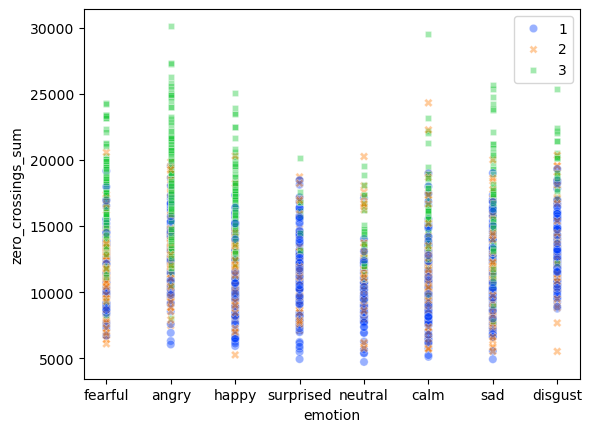

In [118]:
sns.scatterplot(data=df_original, x= "emotion", y= "zero_crossings_sum", hue=w_labels, 
                style=w_labels, palette="bright", alpha = 0.4)
plt.show()

In questo caso lo scatter-plot su emotion della feature che dimostra un buon distanziamento dei centroidi porta a una divisione forse poco netta 
tra i tre cluster, sebbene sussista in qualche caso.

Veloce dimostrazione su come eseguire clustering gerarchico con la libreria di sklearn.cluster. 

N.B. Essendo solo una rapida dimostrazione, ci si basa sulle soluzioni trovate con scipy nella scelta
dei parametri di importanza, come il numero dei cluster.

COMPLETE

In [119]:
model_complete = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete', compute_distances=True)
model_complete = model_complete.fit(norm_df_hier)

In [120]:
model_complete

AgglomerativeClustering(compute_distances=True, linkage='complete',
                        metric='euclidean', n_clusters=3)

In [121]:
#Questa funzione è stata ripresa dalla documentazione 


def plot_dendrogram(model, **kwargs): 
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

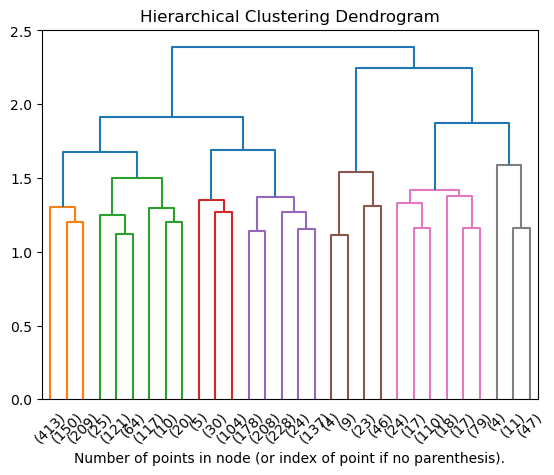

In [122]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_complete, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [123]:
com_labels2 = model_complete.labels_

In [124]:
silhouette_score(norm_df_hier, com_labels2)

0.18735368785465042

Anche nel caso del clusterizzazione con sklearn, il complete linkage vede la produzione di 2 macro-clusters. Questa volta, però, il silhouette score appare più basso, raggiungendo lo 0.25. 

In [125]:
b1 = silhouette_score(norm_df_hier, com_labels2)

SINGLE

In [126]:
model_single = AgglomerativeClustering(n_clusters=9, metric='euclidean', linkage='single', compute_distances=True)
model_single = model_single.fit(norm_df_hier)
model_single

AgglomerativeClustering(compute_distances=True, linkage='single',
                        metric='euclidean', n_clusters=9)

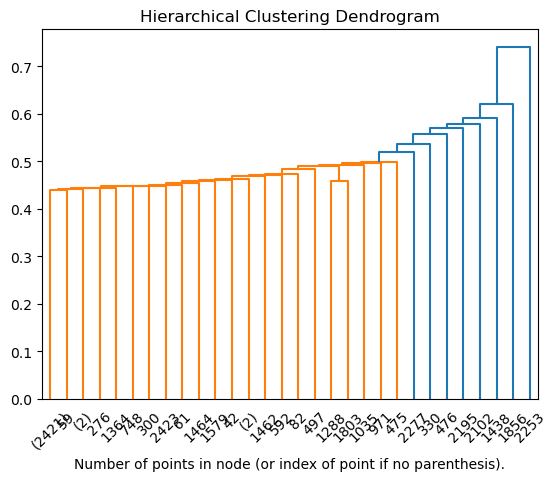

In [127]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_single, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [128]:
sin_labels2 = model_single.labels_
silhouette_score(norm_df_hier, sin_labels2)

0.10689780486935752

I risultati del single linkage con sklearn sono molto simili a quelli precedenti, anche in termini di silhouette. 

In [129]:
b = silhouette_score(norm_df_hier, sin_labels2)

AVERAGE

In [130]:
model_avg = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='average', compute_distances=True)
model_avg = model_avg.fit(norm_df_hier)
model_avg

AgglomerativeClustering(compute_distances=True, linkage='average',
                        metric='euclidean', n_clusters=7)

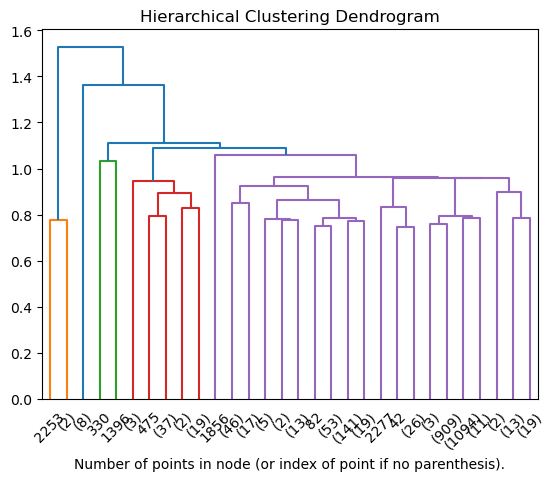

In [131]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_avg, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [132]:
avg_labels2 = model_avg.labels_
silhouette_score(norm_df_hier, avg_labels2)

0.1233246427239758

Per l'average, anche sklearn produce due macro-clusters, sebbene la silhouette fosse poco più alta (0.39) in precedenza. 

In [133]:
b2 = silhouette_score(norm_df_hier, avg_labels2)

In [134]:
model_w = AgglomerativeClustering( n_clusters=3, metric='euclidean', linkage='ward', compute_distances=True)
model_w = model_w.fit(norm_df_hier)
model_w

AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=3)

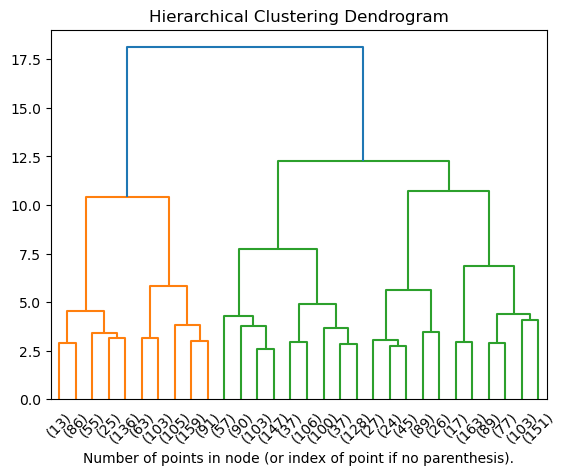

In [135]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model_w, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [136]:
w_labels2 = model_w.labels_
silhouette_score(norm_df_hier, w_labels2)

0.11562485177986392

Proprio come con scipy, il metodo ward produce due clusters - sebbene la silhouette venga fuori più bassa

In [137]:
b3 = silhouette_score(norm_df_hier, w_labels2) 

ALCUNE CONCLUSIONI 

Come volevasi dimostrare, a parità di parametri le librerie scipy e sklarn portamo agli stessi risultati: 



In [138]:
data = {'method': ['scipy', 'sklearn'],
        'single_link': [a, b],
        'complete_link': [a1, b1],
        'avg_link': [a2, b2],
        'ward': [a3, b3]}

In [139]:
pd.DataFrame(data)

method  single_link  complete_link  avg_link      ward
0    scipy     0.106898       0.187354  0.123325  0.115625
1  sklearn     0.106898       0.187354  0.123325  0.115625

Vedendo i risultati in senso stretto, su questo tipo di Dataset la clusterizzazione gerarchica non sembra essere la soluzione migliore.
I risultati sono generalmente insoddisfacenti, forse ad eccezione del metodo ward, che è in grado di creare cluster contenenti 
un numero di punti più significativo ma comunque non ben separato visto il frequente accavallamento delle variabili dei centroidi.

# K-Means

In [140]:
df = pd.read_csv("ravdess_features_base.csv")
df = df.drop(columns=["Unnamed: 0"])

In [141]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

In [142]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

Una volta preparati i dati, possiamo visualizzare la SSE e la Silhouette al variare di K, per trovare il valore ottimale.

In [143]:
%%time
sse_list = []
silhouette_list = []

for k in range(2, 20):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled_data)  # Fit K-means on scaled data
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(numeric_columns, kmeans.labels_))


CPU times: total: 12.1 s
Wall time: 7.68 s


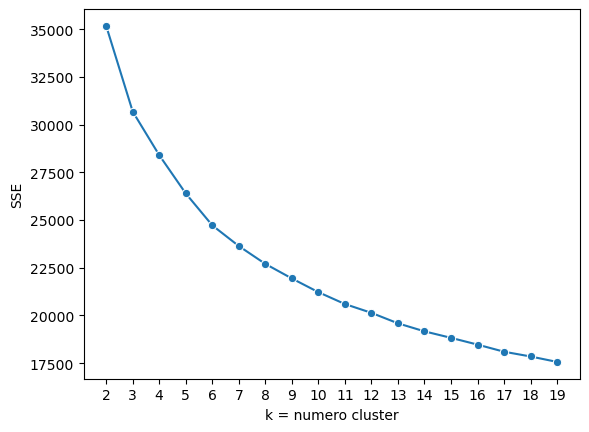

In [144]:
sns.lineplot(x=range(2, 20), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k = numero cluster')
plt.xticks(list(range(2,20)))
plt.show()

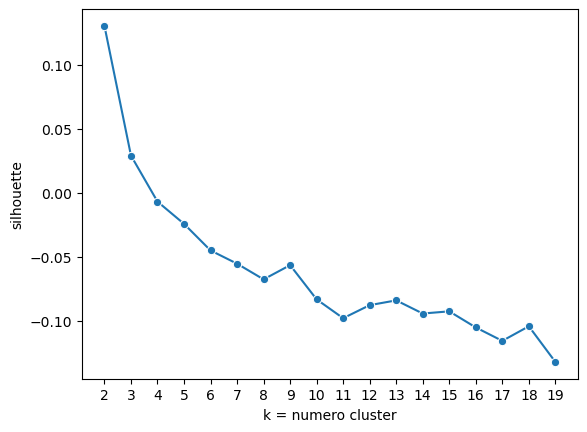

In [145]:
sns.lineplot(x=range(2, 20), y=silhouette_list, marker='o')
plt.ylabel('silhouette')
plt.xlabel('k = numero cluster')
plt.xticks(list(range(2,20)))
plt.show()

In un compromesso tra il silhouette score e l'SSE scegliamo k=5.

Qui abbiamo calcolato gli SSE e silhouette score al variare di k sul dataset non normalizzato. Osserviamo che l'SSE è molto più alto, mentre sul silhouette score raggiungiamo valori migliori, ma questi in realtà non sono significativi perché non avendo normalizzato il dataset le variabili potrebbero essere sbilanciate rispetto al calcolo della distanza.

In [146]:
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(numeric_columns)
    print(f'k={k}, SSE={kmeans.inertia_}, Silhouette Score={silhouette_score(numeric_columns, kmeans.labels_)}')

k=2, SSE=18052964030.43381, Silhouette Score=0.46195166992374914
k=3, SSE=12496409179.677137, Silhouette Score=0.35659710666682837
k=4, SSE=9883876287.826256, Silhouette Score=0.32013849566744856
k=5, SSE=8527152407.273432, Silhouette Score=0.2820839632652294
k=6, SSE=7639719281.442396, Silhouette Score=0.27483071877032345
k=7, SSE=6870278508.040882, Silhouette Score=0.2635569280800135
k=8, SSE=6371399053.472725, Silhouette Score=0.2593930286161853
k=9, SSE=5885134630.986282, Silhouette Score=0.2470148188457428
k=10, SSE=5551078702.003155, Silhouette Score=0.23219448603686066


In [147]:
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(scaled_data)

KMeans(max_iter=100, n_clusters=5, n_init=10)

In [148]:
print("Inertia:", kmeans.inertia_)

Inertia: 26391.25344298591


In [149]:
centroids = kmeans.cluster_centers_

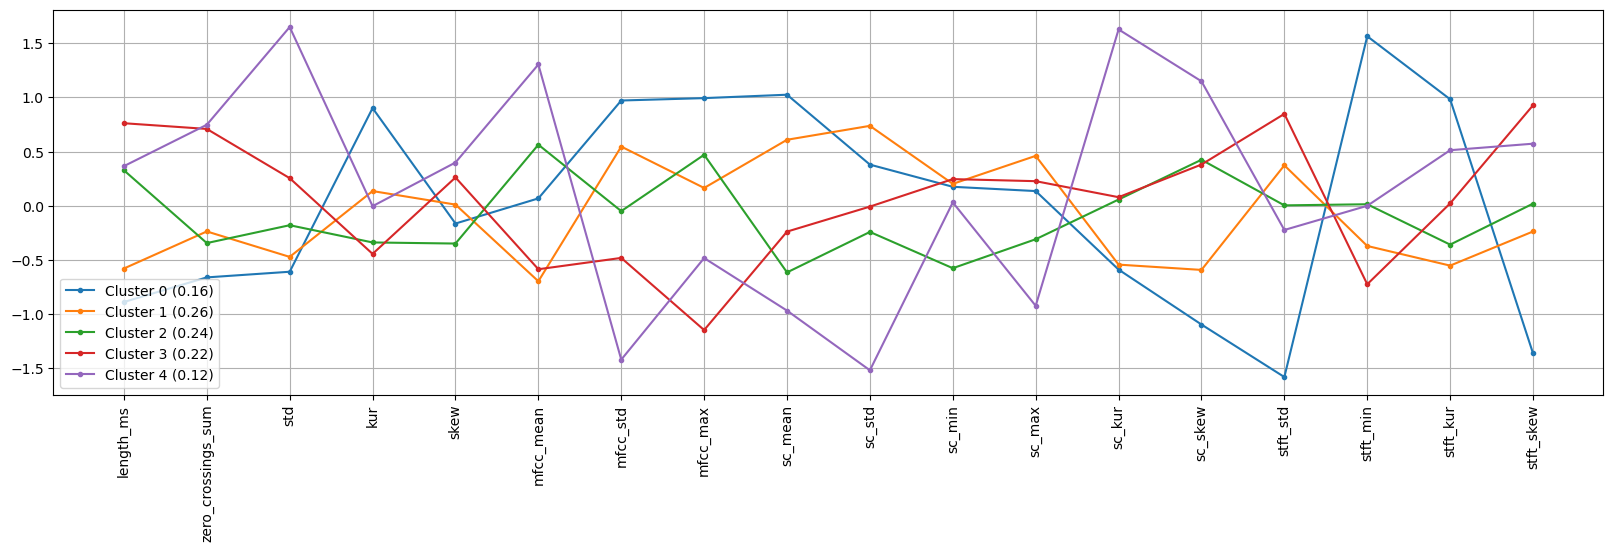

In [150]:
labels, sizes = np.unique(kmeans.labels_, return_counts = True)
plt.figure(figsize = (20,5))

for l in np.unique(kmeans.labels_):
    plt.plot(numeric_columns.columns, centroids[l-1], marker = '.', label = 'Cluster %s (%.2f)' % (l, sizes[l-1]/len(numeric_columns)))

plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

Utilizzando il valore di k che rislta migliore per il l'algoritmo k-means, abbiamo ugualmente una sovrapposizione dei punti, ma ad ogni modo rispetto agli altri algoritmi che abbiamo visto la separazione dei centroidi sembra migliore.

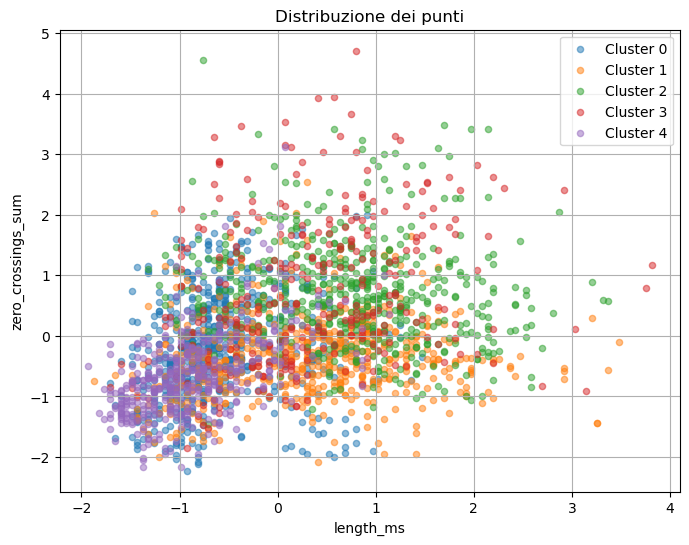

In [151]:
plt.figure(figsize=(8, 6))
for label in np.unique(kmeans.labels_):
    plt.scatter(scaled_data[kmeans.labels_==label, 0], scaled_data[kmeans.labels_==label, 1], label=f'Cluster {label}', s=20, alpha=0.5)
plt.title('Distribuzione dei punti')
plt.legend()
plt.xlabel('length_ms')
plt.ylabel('zero_crossings_sum')
plt.grid(True)
plt.show()

Rispetto a questo scatter plot i cluster risultano molto sovrapposti.

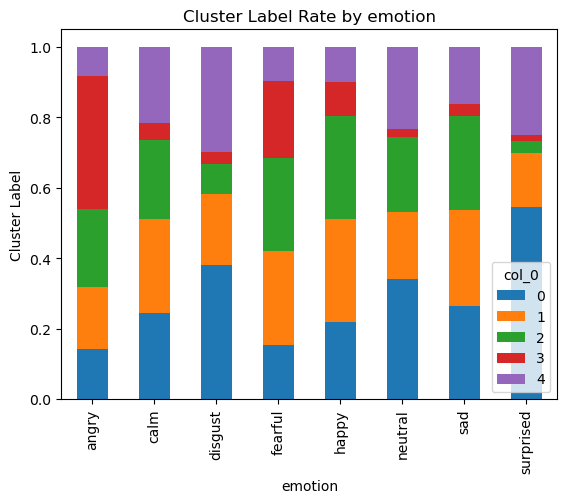

In [152]:
emotion_xt = pd.crosstab(df['emotion'], kmeans.labels_)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('emotion')
plt.ylabel('Cluster Label')
plt.show()

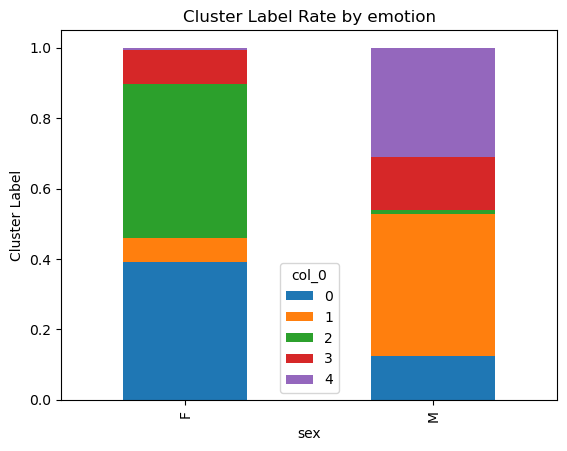

In [153]:
emotion_xt = pd.crosstab(df['sex'], kmeans.labels_)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.show()

La SSE è molto alta. Possiamo provare ad applicare la PCA e il t-sne per affrontare il problema della curse of dimensionality e valutare se si possono ottenere risultati più soddisfacenti.

### PCA

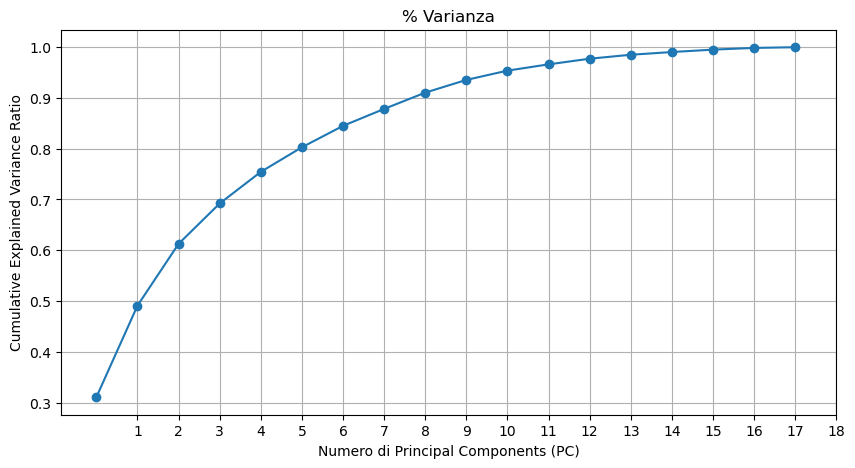

In [154]:
pca = PCA()
numeric_columns_pca = pca.fit_transform(scaled_data)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Numero di Principal Components (PC)')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(list(range(1,19)))
plt.title('% Varianza')
plt.grid(True)
plt.show()

In [155]:
pca = PCA(n_components=5)
numeric_columns_pca = pca.fit_transform(scaled_data)

In [156]:
sse_list_pca = []
silhouette_list_pca = []
for k in range(2, 20):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(numeric_columns_pca)
    sse_list_pca.append(kmeans.inertia_)
    silhouette_list_pca.append(silhouette_score(numeric_columns_pca, kmeans.labels_))

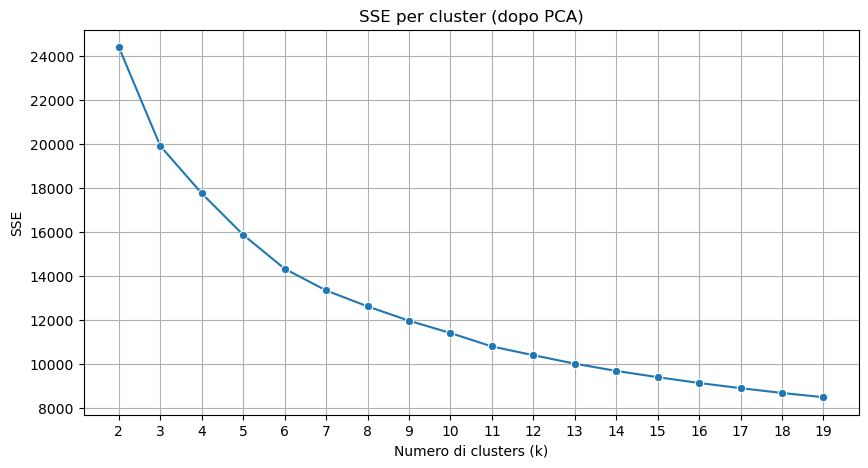

In [157]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(2, 20), y=sse_list_pca, marker='o')
plt.ylabel('SSE')
plt.xlabel('Numero di clusters (k)')
plt.xticks(list(range(2,20)))
plt.title('SSE per cluster (dopo PCA)')
plt.grid(True)
plt.show()

L'SSE migliora e la curva si appiattisce più velocemente.

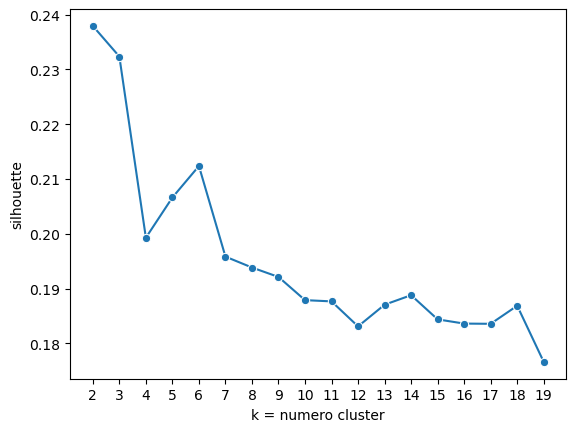

In [158]:
sns.lineplot(x=range(2, 20), y=silhouette_list_pca, marker='o')
plt.ylabel('silhouette')
plt.xlabel('k = numero cluster')
plt.xticks(list(range(2,20)))
plt.show()

Confrontando i grafici di SSE e silhouette una buona scelta del k ci sembra sei.

In [159]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=100)
kmeans.fit(numeric_columns_pca)

KMeans(max_iter=100, n_clusters=6, n_init=10)

In [160]:
#questo ci servirà per il report finale
pca1 = round(silhouette_score(numeric_columns_pca, kmeans.labels_), 2)
pca2 = round(kmeans.inertia_, 2)

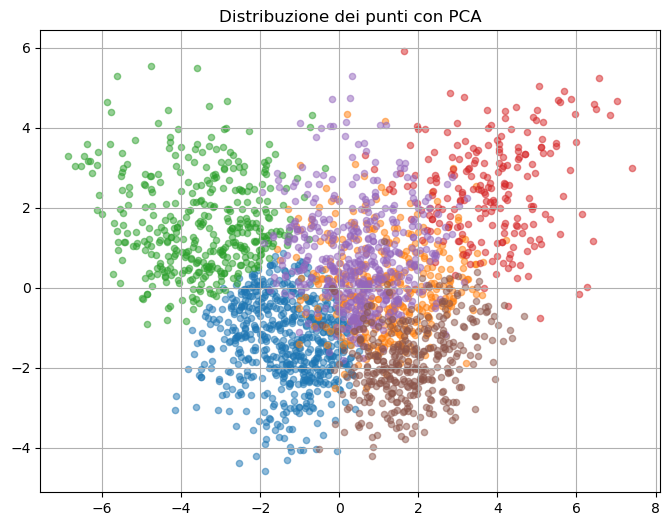

In [161]:
plt.figure(figsize=(8, 6))
for label in np.unique(kmeans.labels_):
    plt.scatter(numeric_columns_pca[kmeans.labels_==label, 0], numeric_columns_pca[kmeans.labels_==label, 1], label=f'Cluster {label}', s=20, alpha=0.5)
plt.title('Distribuzione dei punti con PCA')
plt.grid(True)
plt.show()

La ripartizione dei punti sembra essere migliorata, con una sovrapposizione minore tra i vari cluster.

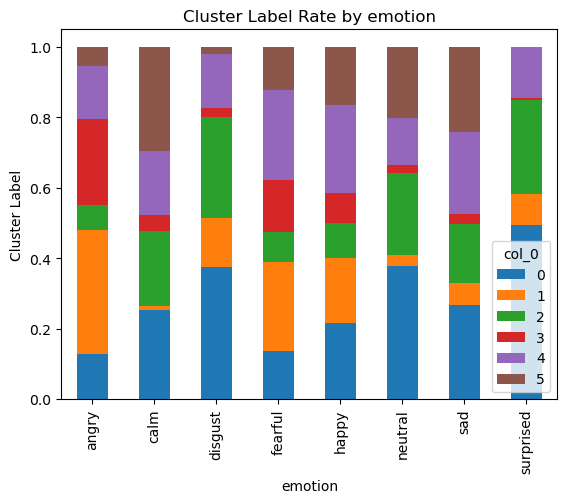

In [162]:
emotion_xt = pd.crosstab(df['emotion'], kmeans.labels_)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('emotion')
plt.ylabel('Cluster Label')
plt.show()

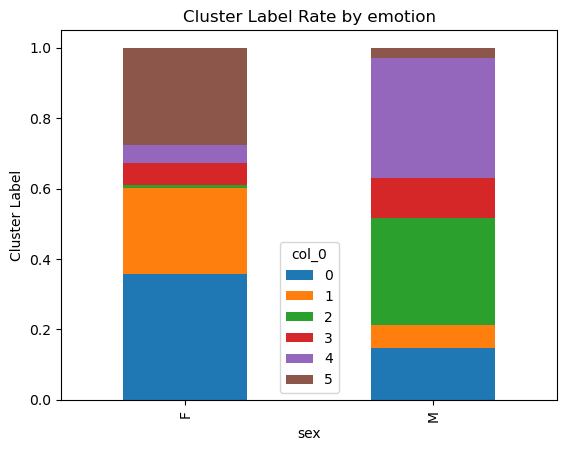

In [163]:
emotion_xt = pd.crosstab(df['sex'], kmeans.labels_)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.show()

## T-sne

In [164]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(numeric_columns)
tsne_data = scaler.fit_transform(tsne_data)
tsne_df = pd.DataFrame(data=tsne_data, columns=['Component 1', 'Component 2'])

In [165]:
sse_list_tsne_p = []
silhouette_list_tsne_p = []
for k in range(2, 20):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(tsne_data)
    sse_list_tsne_p.append(kmeans.inertia_)
    silhouette_list_tsne_p.append(silhouette_score(tsne_data, kmeans.labels_))

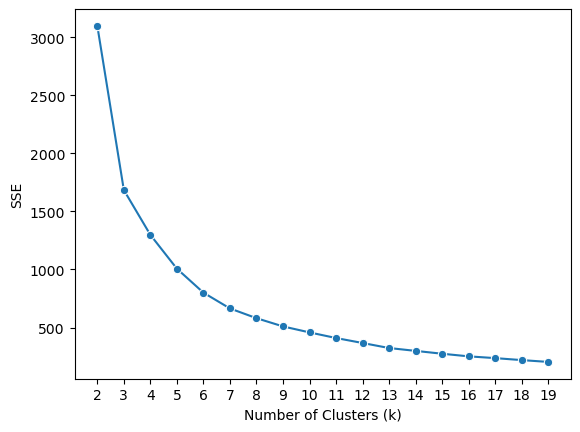

In [166]:
sns.lineplot(x=range(2, 20), y=sse_list_tsne_p, marker='o')
plt.ylabel('SSE')
plt.xlabel('Number of Clusters (k)')
plt.xticks(list(range(2,20)))
plt.show()

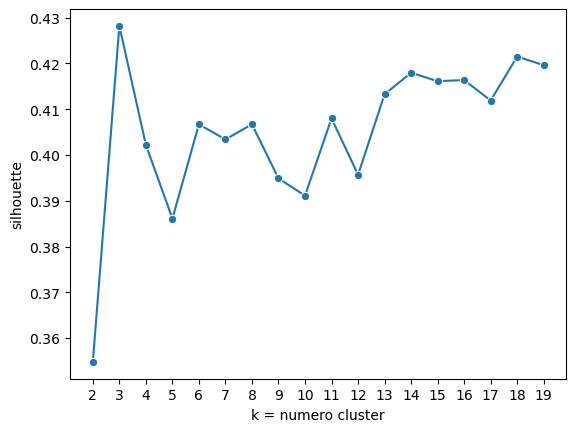

In [167]:
sns.lineplot(x=range(2,20), y=silhouette_list_tsne_p, marker='o')
plt.ylabel('silhouette')
plt.xlabel('k = numero cluster')
plt.xticks(list(range(2,20)))
plt.show()

Come già fatto in precedenza dal confronto fra SSE e silhouette scegliamo k=6.

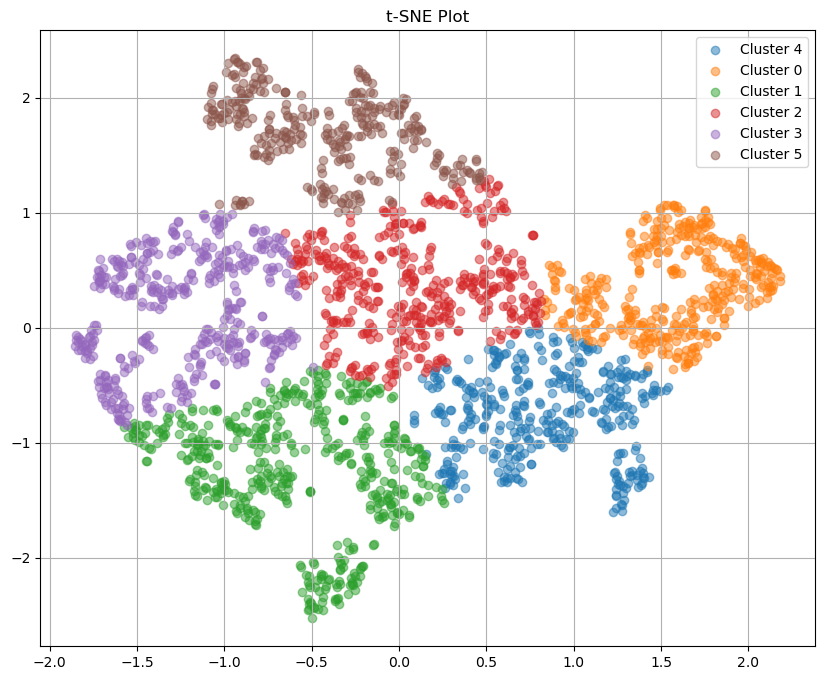

In [168]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_data)

tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
for cluster in tsne_df['Cluster'].unique():
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster]
    plt.scatter(cluster_data['Component 1'], cluster_data['Component 2'], label=f'Cluster {cluster}', alpha=0.5)
plt.title(f't-SNE Plot')
plt.grid(True)
plt.legend()
plt.show()

Con la t-sne abbiamo ridotto a 2 le dimensioni dei dati e successivamente abbiamo applicato il kmeans, come ci aspettavamo ha portato a formare dei cluster globulari.

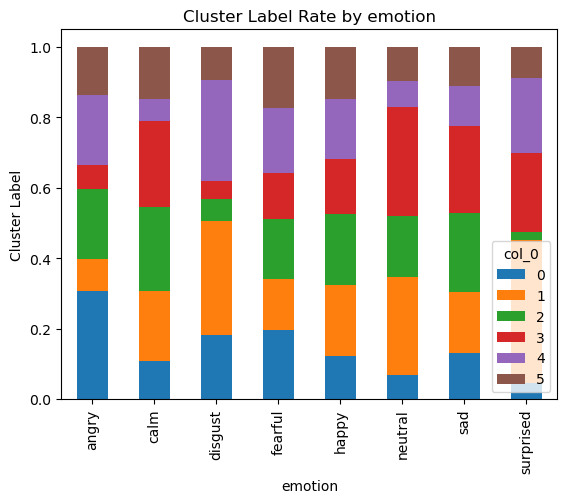

In [169]:
emotion_xt = pd.crosstab(df['emotion'], cluster_labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('emotion')
plt.ylabel('Cluster Label')
plt.show()

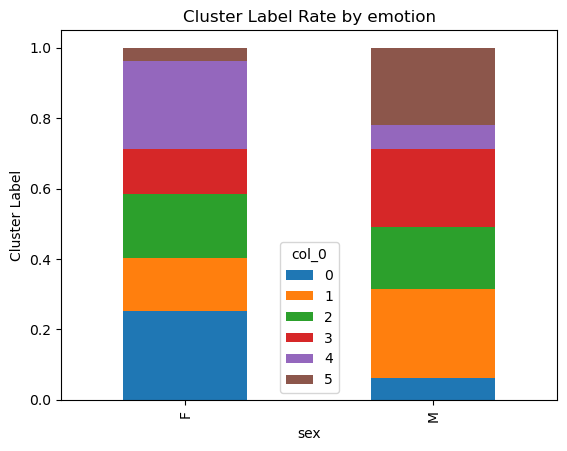

In [170]:
emotion_xt = pd.crosstab(df['sex'], cluster_labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.show()

I valori migliori per SSE e silhouette si ottengono utilizzando t-sne. Anche dal punto di vista della visualizzazione il t-sne è più efficace. In conclusione il t-sne, dal punto di vista dell'SSE e della silhouette è risultato il metodo migliore per ridurre la dimensione in dati in preparazione al kmeans.

In [171]:
#questo ci servirà per il report finale
tsne1 = round(silhouette_score(tsne_data, kmeans.labels_), 2)
tsne2 = round(kmeans.inertia_, 2)

## Bisecting K-Means
Sperimentiamo il clustering con un approccio diverso, tra il gerarchico e il partizionale. 

#### Modello

In [172]:
scaled_data = scaler.fit_transform(numeric_columns)

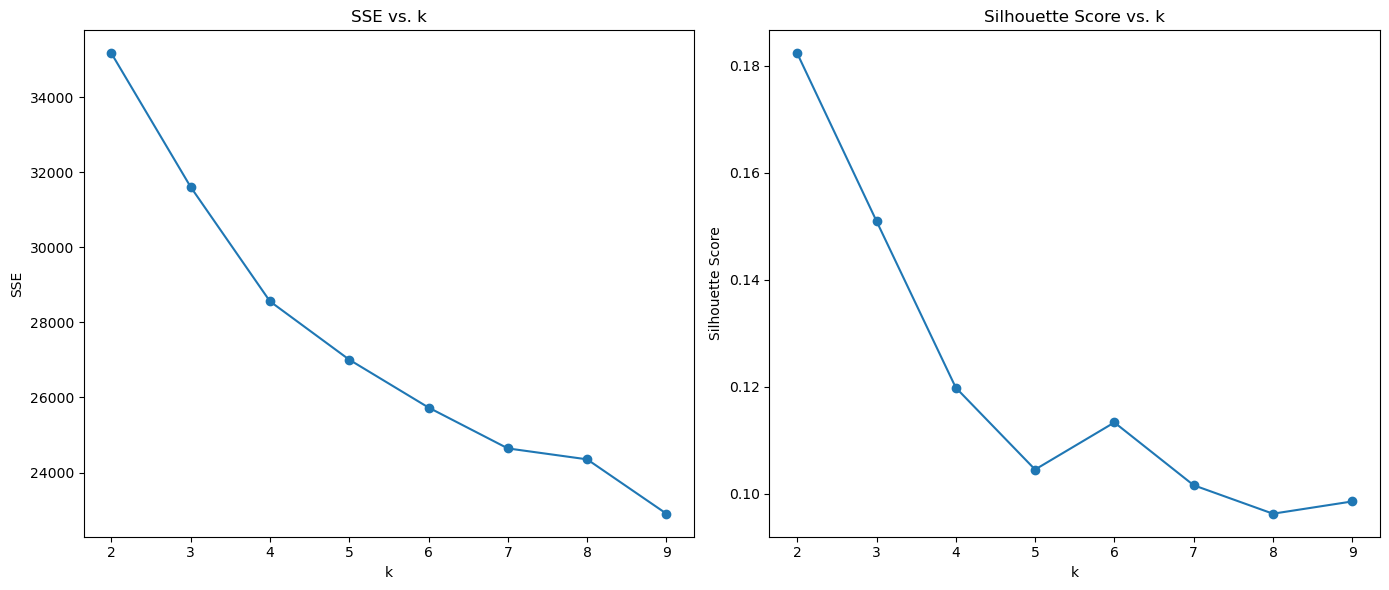

In [173]:
k_values = range(2, 10)  # For example, from 2 to 9

sse = []
silhouette_scores = []

for k in k_values:
    bisecting_kmeans = BisectingKMeans(n_clusters=k)
    bisecting_kmeans.fit(scaled_data)
    sse_value = bisecting_kmeans.inertia_
    silhouette_score_value = silhouette_score(scaled_data, bisecting_kmeans.labels_, metric='euclidean')
    sse.append(sse_value)
    silhouette_scores.append(silhouette_score_value)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, sse, '-o')
plt.title('SSE vs. k')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(list(k_values))

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, '-o')
plt.title('Silhouette Score vs. k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xticks(list(k_values))

plt.tight_layout()
plt.show()


## Bisecting K-means

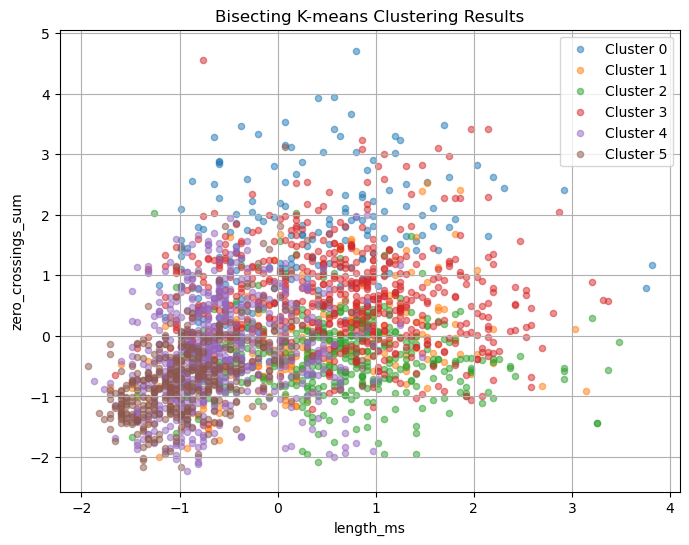

In [174]:
k = 6
bisecting_kmeans = BisectingKMeans(n_clusters=k)
bisecting_kmeans.fit(scaled_data)
labels = bisecting_kmeans.labels_
sse = bisecting_kmeans.inertia_
silhouette = silhouette_score(scaled_data, bisecting_kmeans.labels_, metric='euclidean')

plt.figure(figsize=(8, 6))
for label in np.unique(bisecting_kmeans.labels_):
    plt.scatter(scaled_data[bisecting_kmeans.labels_==label, 0], scaled_data[bisecting_kmeans.labels_==label, 1], label=f'Cluster {label}', s=20, alpha=0.5)
plt.title('Bisecting K-means Clustering Results')
plt.xlabel(numeric_columns.columns[0])
plt.ylabel(numeric_columns.columns[1])
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=bisecting_kmeans.labels_, cmap='viridis', marker='o', alpha=0.5)
# plt.title("Bisecting K-means Clustering Results")
# plt.xlabel(numeric_columns.columns[0])
# plt.ylabel(numeric_columns.columns[1])
# plt.legend()
# plt.show()

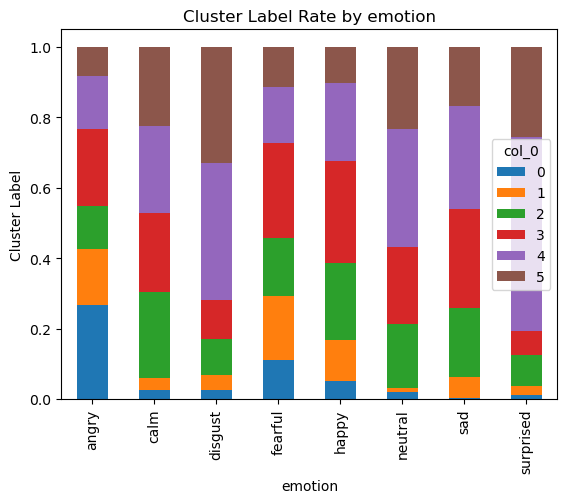

In [175]:
emotion_xt = pd.crosstab(df['emotion'], labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('emotion')
plt.ylabel('Cluster Label')
plt.show()

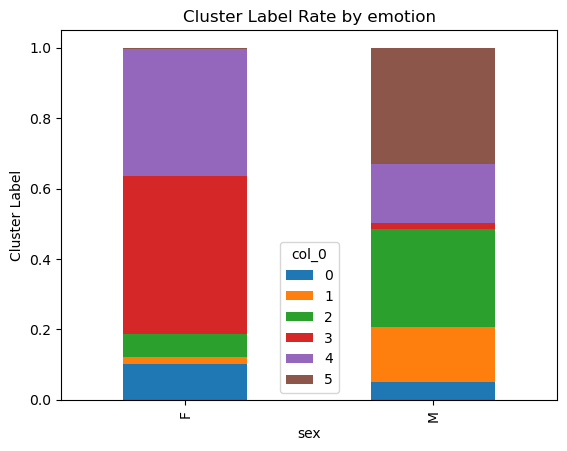

In [176]:
emotion_xt = pd.crosstab(df['sex'], labels)
emotion_xt_pct = emotion_xt.div(emotion_xt.sum(1).astype(float), axis=0)
emotion_xt_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by emotion')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.show()

# CONCLUSIONI

In [177]:
data = {'measure': ['SSE', 'Silhouette'], # la precision è calcolata con average='macro'
        'Hierarchical Ward': ["", round(b3,2)],
        'DBSCAN': ["", round(max_silhouette,2)],
        'K-Means PCA': [pca2, pca1],
        'K-Means T-SNE': [tsne2, tsne1],
        'Bisecting K-Means': [round(sse,2), round(silhouette,2)]}

In [178]:
pd.DataFrame(data)

measure Hierarchical Ward DBSCAN  K-Means PCA  K-Means T-SNE  \
0         SSE                              14316.04         800.59   
1  Silhouette              0.12   0.34         0.21           0.41   

   Bisecting K-Means  
0           25580.58  
1               0.12

Dalla nostra analisi possiamo osservare che il DBSCAN, nonostante vada a produrre una clusterizzazione poco utile (si ottiene sempre un cluster molto grosso, eventualmente qualche altro cluster molto piccolo e tutto il resto finisce in rumore), si distingue magari per la sua capacità di individuare gli outlier.  

Il Hierarchical Clustering non ha performance sufficienti (dal punto di vista della silhouette) ma utilizzando il metodo Ward si riesce ad ottenere un compromesso tra il numero di cluster prodotti e il silhouette score, nonostante rimanga molto basso, non rendendo quindi questo algoritmo il migliore per questo dataset. Infatti, il metodo agglomerativo in generale porta alla creazione di molti singleton. Ciò ha aiutato per trovare gli outliers ma contemporaneamente ne ha compromesso i risultati. Inoltre abbiamo osservato che il clustering prodotto dal complete linkage riesce a inserire in un unico cluster tutti i punti con emozione surprised come già commentato. Questo ci fa supporre che il complete linkage per quanto poco performante rispetto al silhouette score, riesce comunque a individuare una qualche struttura nel dataset.  

I risultati migliori dal punto di vista della silhouette e dell'SSE si ottengono con K-means dopo aver applicato t-sne. Va comunque sottolineato che la riduzione numerica delle variabili porta inevitabilmente ad una sommatoria di valore inferiore, il che garantisce un SSE più basso. Inoltre confrontando la distribuzione dei record nei cluster rispetto alle variabili categoriche sex ed emotion, notiamo che ha performance peggiori rispetto ad altri algoritmi visti.  

L'algoritmo Bisecting K-means ha pessime prestazioni (SSE e Silhouette), tuttavia dal grafico sulla distribuzione dei punti nei cluster rispetto alla variabile sex, notiamo che che il cluster 1 contiene quasi solo maschi e il cluster 3 quasi solo femmine, quindi una qualche struttura nel dataset riesce a trovarla.  

Il dataset in definitiva non risulta facilmente clusterizzabile, anche perché i data points sono tutti estremamente sovrapposti.
In conclusione la nostra impressione è che non ci sia un vero algoritmo da preferire per la clusterizzazione di questo dataset; piuttosto suggeriamo che i diversi algoritmi propongono tutti una prospettiva interessante rispetto a cui analizzare il dataset. Un approccio integrativo, che prende in considerazione quello che i diversi algoritmi possono permetterci di dire sul dataset, rimane forse il migliore.